# 🧬 StrandWeaver — SVScribe Training v5 (Colab GPU)

**Two-stage SV detection** with XGBoost + LightGBM ensemble and per-class threshold tuning.

| Stage | Task | Classes | Model |
|-------|------|---------|-------|
| **Stage 1** | Binary SV detection | `background` \| `SV` | XGBoost |
| **Stage 2** | SV subtype classification | `deletion` \| `insertion` \| `inversion` \| `duplication` | XGBoost + LightGBM ensemble |

> **v5 key changes:**
> - XGBoost + LightGBM ensemble blend (algorithmic diversity)
> - Per-class threshold optimization (fixes inversion FP / duplication FN imbalance)
> - Removed post-prediction Bayesian calibration (α→0, confirmed ineffective)
> - Kept bio composite features as regular model inputs (effective as standard features)

**Training data layout (5 batches × 40 genomes = 200 genomes):**
```
training_data_sv_dense/
├── sv_dense_1e4/          Moderate SV density (10× baseline), all 4 types
├── sv_dense_2e4/          High SV density (20× baseline), higher repeats
├── sv_dense_3e4/          Very high SV density (30× baseline)
├── sv_dense_ins_focus/    Insertion-enriched (50% insertion, 50% other)
├── sv_dense_inv_dup_focus/ Inversion+duplication-enriched
└── sv_dense_generation_report.json
```

### Feature Groups (39 features, `breakpoint_precision` excluded)

| # | Group | Features |
|---|-------|---------|
| 1–6 | Metadata | genome_size, coverage_depth, error_rate, gc_content_global, repeat_density_global, heterozygosity_rate |
| 7–11 | Coverage stats | coverage_mean, coverage_std, coverage_median, gc_content, repeat_fraction |
| 12–16 | Graph topology | kmer_diversity, branching_complexity, hic_disruption_score, ul_support, mapping_quality |
| 17–21 | Region signals | region_length, allele_balance, phase_switch_rate, coverage_cv, coverage_skewness |
| 22–26 | Distribution stats | coverage_kurtosis, coverage_p10, coverage_p90, depth_ratio_flank, split_read_count |
| 27–32 | SV signatures | clip_fraction, bubble_size, path_divergence, ul_spanning, coverage_drop_magnitude, orientation_switch_rate |
| 33–39 | Engineered (v2) | inv_signal, del_signal, dup_signal, split_read_ratio, coverage_asymmetry, sv_complexity_score, coverage_stability |

### Setup
1. `Runtime → Change runtime type → T4 GPU` (or A100 if available)
2. Upload `training_data_sv_dense/` to Google Drive (or generate on Colab)
3. Run cells top-to-bottom

> **Output:** `sv_binary_model.pkl` + `sv_subtype_model.pkl` → drop into `strandweaver/trained_models/sv_detector/`
> The inference module (`sv_detection.py`) auto-detects ensemble models.

## 1. Environment Setup

In [1]:
# ── Verify GPU ──────────────────────────────────────────────────────
import subprocess, sys, os

result = subprocess.run(
    ['nvidia-smi', '--query-gpu=name,memory.total,driver_version', '--format=csv,noheader'],
    capture_output=True, text=True
)
if result.returncode == 0:
    print(f"✓ GPU detected: {result.stdout.strip()}")
    GPU_AVAILABLE = True
else:
    print("⚠ No GPU detected — XGBoost will use CPU (still fast, just slower HP search)")
    GPU_AVAILABLE = False

# Check RAM
import psutil
ram_gb = psutil.virtual_memory().total / 1e9
print(f"✓ RAM: {ram_gb:.1f} GB {'(High-RAM ✓)' if ram_gb > 20 else '(consider High-RAM runtime)'}")
print(f"✓ Python: {sys.version.split()[0]}")

✓ GPU detected: NVIDIA RTX PRO 6000 Blackwell Server Edition, 97887 MiB, 580.82.07
✓ RAM: 189.9 GB (High-RAM ✓)
✓ Python: 3.12.12


In [ ]:
# ── Install dependencies ────────────────────────────────────────────
!pip install -q xgboost scikit-learn numpy pandas optuna matplotlib seaborn lightgbm

# Clone StrandWeaver (dev branch) and install — pull latest on re-runs
!git clone -b dev https://github.com/pgrady1322/strandweaver.git /content/strandweaver 2>/dev/null || \
    (cd /content/strandweaver && git pull origin dev)
!cd /content/strandweaver && pip install -e . -q

print("\n✓ Dependencies installed")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 15.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 140.7 MB/s eta 0:00:00
  Building editable for strandweaver (pyproject.toml) ... done

✓ Dependencies installed


In [3]:
# ── Mount Google Drive (for data + saving results) ──────────────────
from google.colab import drive
drive.mount('/content/drive')

# ── Directory layout ────────────────────────────────────────────────
GDRIVE_DIR        = '/content/drive/MyDrive/Colab_Training'
SVSCRIBE_OUT      = '/content/svscribe_training'
MODELS_OUT        = '/content/trained_models'
GDRIVE_SVSCRIBE   = os.path.join(GDRIVE_DIR, 'svscribe_models')

for d in [GDRIVE_DIR, SVSCRIBE_OUT, MODELS_OUT]:
    os.makedirs(d, exist_ok=True)

print(f"✓ Google Drive mounted")
print(f"✓ Working dirs created")
print(f"  SVScribe output:  {SVSCRIBE_OUT}")
print(f"  Models output:    {MODELS_OUT}")
print(f"  Drive export:     {GDRIVE_DIR}")

Mounted at /content/drive
✓ Google Drive mounted
✓ Working dirs created
  SVScribe output:  /content/svscribe_training
  Models output:    /content/trained_models
  Drive export:     /content/drive/MyDrive/Colab_Training


In [4]:
# ── Verify imports ──────────────────────────────────────────────────
import xgboost as xgb
import numpy as np
import pandas as pd
import time
import json
import pickle
import logging
from pathlib import Path
from collections import Counter

logging.basicConfig(level=logging.INFO, format='%(asctime)s [%(levelname)s] %(message)s', datefmt='%H:%M:%S')
logger = logging.getLogger('svscribe_training')

SEED = 42

# XGBoost device config
XGB_DEVICE = 'cuda' if GPU_AVAILABLE else 'cpu'
XGB_TREE = 'hist'  # gpu_hist deprecated in XGBoost 2.x — 'hist' auto-uses GPU

print(f"✓ XGBoost {xgb.__version__}")
print(f"✓ NumPy {np.__version__}")
print(f"✓ Pandas {pd.__version__}")
print(f"✓ Device: {XGB_DEVICE}")

✓ XGBoost 3.2.0
✓ NumPy 2.0.2
✓ Pandas 2.2.2
✓ Device: cuda


## 2. Configuration

Edit the cell below to point to your SV training data.

**Option A (recommended):** Upload the `training_data_sv_dense/` directory to Google Drive.

**Option B:** Generate training data on Colab:
```bash
cd /content/strandweaver
python strandweaver/user_training/generate_training_data.py \
    --genome-size 2000000 -n 40 --sv-density 0.0001 \
    --sv-types deletion insertion inversion duplication \
    --read-types hifi --coverage 30 --graph-training \
    -o /content/sv_training_data --seed 42
```

In [ ]:
# ══════════════════════════════════════════════════════════════════════
#  v5: SVScribe Configuration — Ensemble Blend + Threshold Tuning
# ══════════════════════════════════════════════════════════════════════
import os, matplotlib.pyplot as plt, seaborn as sns

MODELS_OUT = '/content/models'
SVSCRIBE_OUT = os.path.join(MODELS_OUT, 'svscribe')
os.makedirs(SVSCRIBE_OUT, exist_ok=True)

# ── Google Drive paths ──────────────────────────────────────────────
GDRIVE_DIR = '/content/drive/MyDrive/Colab_Training'
GDRIVE_SVSCRIBE = os.path.join(GDRIVE_DIR, 'svscribe_models')
os.makedirs(GDRIVE_DIR, exist_ok=True)

# ── Training data ──────────────────────────────────────────────────
SV_DATA_DIR = os.path.join(GDRIVE_DIR, 'training_data_sv_dense')
SV_BATCHES = [
    'sv_dense_1e4',
    'sv_dense_2e4',
    'sv_dense_3e4',
    'sv_dense_ins_focus',
    'sv_dense_inv_dup_focus',
]

# ── SV type labels ─────────────────────────────────────────────────
SV_TYPE_MAP = {'none': 0, 'deletion': 1, 'insertion': 2, 'inversion': 3, 'duplication': 4}
SV_TYPE_NAMES = {0: 'none', 1: 'deletion', 2: 'insertion', 3: 'inversion', 4: 'duplication'}
SUBTYPE_MAP = {'deletion': 0, 'insertion': 1, 'inversion': 2, 'duplication': 3}
SUBTYPE_NAMES = {0: 'deletion', 1: 'insertion', 2: 'inversion', 3: 'duplication'}

# ── Feature groups ──────────────────────────────────────────────────
METADATA_FEATURES = [
    'genome_size', 'coverage_depth', 'error_rate',
    'gc_content_global', 'repeat_density_global', 'heterozygosity_rate',
]

SIGNAL_FEATURES = [
    'coverage_mean', 'coverage_std', 'coverage_median',
    'gc_content', 'repeat_fraction',
    'kmer_diversity', 'branching_complexity',
    'hic_disruption_score', 'ul_support', 'mapping_quality',
    'region_length', 'allele_balance',
    'phase_switch_rate', 'coverage_cv',
    'coverage_skewness', 'coverage_kurtosis',
    'coverage_p10', 'coverage_p90', 'depth_ratio_flank',
    'split_read_count', 'clip_fraction',
    'bubble_size', 'path_divergence', 'ul_spanning',
    'coverage_drop_magnitude', 'orientation_switch_rate',
]

ENGINEERED_FEATURES = [
    # v2: basic interaction features
    'inv_signal',            # orientation_switch × (1 - |cov_drop|)
    'del_signal',            # cov_drop × (1 - orientation_switch)
    'dup_signal',            # depth_ratio_flank × (1 - cov_drop)
    'split_read_ratio',      # split_read_count / (coverage_mean + 1)
    'coverage_asymmetry',    # |coverage_p90 - coverage_p10| / (coverage_median + 1)
    'sv_complexity_score',   # branching × kmer_diversity × bubble_size
    'coverage_stability',    # 1 / (coverage_cv + 0.01)
    # v3.1: type-discriminative indicators
    'cov_drop_indicator',    # max(0, cov_drop_mag)
    'cov_gain_indicator',    # max(0, -cov_drop_mag)
    'flank_asymmetry',       # |depth_ratio_flank - 1|
    'strand_switch_density', # orientation_switch × split_read_count
    'clip_split_signal',     # clip_fraction × split_read_ratio
    # v4: biology-informed composite scores (used as standard features)
    'bio_del_score',         # weighted sum of deletion-associated features
    'bio_ins_score',         # weighted sum of insertion-associated features
    'bio_inv_score',         # weighted sum of inversion-associated features
    'bio_dup_score',         # weighted sum of duplication-associated features
    # v4.1: mapping quality deficit (high = low mapQ → repeated/ambiguous sequence)
    'mapq_deficit',          # max(0, median_mapq - mapping_quality)
]

# ── Bio composite score weights ─────────────────────────────────────
# Domain knowledge from classical SV callers (DELLY, LUMPY, Sniffles,
# SVIM, CuteSV). Used ONLY for computing bio_*_score features in
# the data inspect cell. NOT used for post-prediction calibration
# (v4's Bayesian calibration was confirmed ineffective, α→0).
BIO_PRIOR_RULES = {
    'deletion': {
        'cov_drop_indicator':      2.0,   # coverage loss (core deletion signal)
        'del_signal':              1.5,   # cov_drop × (1 - orientation_switch)
        'split_read_count':        0.8,   # breakpoint reads
        'path_divergence':         1.0,   # graph paths that bypass deleted nodes
        'hic_disruption_score':    0.5,   # discordant paired-end mapping
    },
    'insertion': {
        'clip_fraction':           2.0,   # soft-clipping from inserted sequence
        'clip_split_signal':       1.5,   # clip × split interaction
        'split_read_ratio':        1.5,   # high split/coverage ratio
        'bubble_size':             0.8,   # GFA bubbles from insertion allele
        'hic_disruption_score':    0.5,   # paired-end insert-size anomaly
        'path_divergence':         0.5,   # shorter → longer path fork in graph
    },
    'inversion': {
        'orientation_switch_rate': 2.5,   # strand reversal (core inversion signal)
        'strand_switch_density':   2.0,   # switch × split_read_count
        'hic_disruption_score':    2.0,   # Hi-C butterfly / pair disruption
        'ul_spanning':             1.5,   # long reads span entire inversion
        'split_read_count':        0.5,   # breakpoint split reads (fwd/RC split)
    },
    'duplication': {
        'ul_spanning':             2.5,   # UL reads bridge duplicated region
        'cov_gain_indicator':      2.5,   # coverage increase
        'flank_asymmetry':         1.5,   # flanking coverage imbalance
        'path_divergence':         1.0,   # duplicated / circular graph paths
        'mapq_deficit':            0.8,   # low mapQ from repeated sequence
    },
}

BIO_TYPE_ORDER = ['deletion', 'insertion', 'inversion', 'duplication']

# ── Separate feature sets per stage ─────────────────────────────────
ALL_FEATURES = METADATA_FEATURES + SIGNAL_FEATURES + ENGINEERED_FEATURES
S1_FEATURES = ALL_FEATURES
S2_FEATURES = SIGNAL_FEATURES + ENGINEERED_FEATURES  # signal-only for subtype
SV_LABEL = 'sv_type'

# ── Training hyperparameters ────────────────────────────────────────
N_OPTUNA_TRIALS_S1 = 40    # Stage 1 (binary)
N_OPTUNA_TRIALS_S2 = 80    # Stage 2 (per model — XGBoost and LightGBM each)
N_CV_FOLDS = 5

# ── Validate data directory ────────────────────────────────────────
print(f"SV data directory: {SV_DATA_DIR}")
print(f"S1 features: {len(S1_FEATURES)} (meta + signal + engineered)")
print(f"S2 features: {len(S2_FEATURES)} (signal + engineered — NO metadata)")
print()
for batch in SV_BATCHES:
    batch_path = os.path.join(SV_DATA_DIR, batch)
    if os.path.isdir(batch_path):
        n_genomes = len([d for d in os.listdir(batch_path) if d.startswith('genome_')])
        print(f"  ✓ {batch}: {n_genomes} genomes")
    else:
        print(f"  ✗ {batch}: NOT FOUND at {batch_path}")

report_path = os.path.join(SV_DATA_DIR, 'sv_dense_generation_report.json')
if os.path.exists(report_path):
    with open(report_path) as f:
        report = json.load(f)
    for name, batch_info in report.get('batches', {}).items():
        status = batch_info.get('status', 'unknown')
        elapsed = batch_info.get('elapsed_seconds', 0)
        print(f"  {name}: {status} ({elapsed/60:.1f} min)")
else:
    print(f"  ⚠ Generation report not found at {report_path}")

SV data directory: /content/drive/MyDrive/Colab_Training/training_data_sv_dense
  ✓ sv_dense_1e4: 40 genomes
  ✓ sv_dense_2e4: 40 genomes
  ✓ sv_dense_3e4: 40 genomes
  ✓ sv_dense_ins_focus: 40 genomes
  ✓ sv_dense_inv_dup_focus: 40 genomes
  sv_dense_1e4: success (158.1 min)
  sv_dense_2e4: success (129.7 min)
  sv_dense_3e4: success (91.8 min)
  sv_dense_inv_dup_focus: success (123.2 min)
  sv_dense_ins_focus: success (222.4 min)


## 3. Load & Merge Training Data
Loads `sv_detect_training_*.csv` from all batches and genomes into a single DataFrame.

In [6]:
# ── Concatenate all SV detect CSVs ──────────────────────────────────
frames = []
batch_counts = {}

for batch in SV_BATCHES:
    batch_dir = os.path.join(SV_DATA_DIR, batch)
    if not os.path.isdir(batch_dir):
        print(f"  ⚠ Skipping {batch} (not found)")
        continue

    batch_frames = []
    for gdir in sorted(os.listdir(batch_dir)):
        gt_dir = os.path.join(batch_dir, gdir, 'graph_training')
        if not os.path.isdir(gt_dir):
            continue
        for fname in os.listdir(gt_dir):
            if fname.startswith('sv_detect_training_'):
                csv_path = os.path.join(gt_dir, fname)
                df = pd.read_csv(csv_path)
                df['batch'] = batch
                batch_frames.append(df)

    if batch_frames:
        batch_df = pd.concat(batch_frames, ignore_index=True)
        batch_counts[batch] = len(batch_df)
        frames.append(batch_df)
        print(f"  ✓ {batch}: {len(batch_df):,} rows from {len(batch_frames)} files")

df_all = pd.concat(frames, ignore_index=True)
print(f"\n{'═'*50}")
print(f"Total rows: {len(df_all):,}")
print(f"Columns:    {len(df_all.columns)}")
print(f"Batches:    {len(batch_counts)}")
for b, n in batch_counts.items():
    print(f"  {b}: {n:,} ({n/len(df_all)*100:.1f}%)")

  ✓ sv_dense_1e4: 16,255 rows from 40 files
  ✓ sv_dense_2e4: 16,973 rows from 40 files
  ✓ sv_dense_3e4: 14,562 rows from 40 files
  ✓ sv_dense_ins_focus: 28,622 rows from 40 files
  ✓ sv_dense_inv_dup_focus: 18,046 rows from 40 files

══════════════════════════════════════════════════
Total rows: 94,458
Columns:    42
Batches:    5
  sv_dense_1e4: 16,255 (17.2%)
  sv_dense_2e4: 16,973 (18.0%)
  sv_dense_3e4: 14,562 (15.4%)
  sv_dense_ins_focus: 28,622 (30.3%)
  sv_dense_inv_dup_focus: 18,046 (19.1%)


## 4. Inspect & Preprocess Data

In [ ]:
# ── Encode labels ───────────────────────────────────────────────────
df_all['sv_type_encoded'] = df_all[SV_LABEL].map(SV_TYPE_MAP)

unmapped = df_all[df_all['sv_type_encoded'].isna()][SV_LABEL].unique()
if len(unmapped) > 0:
    print(f"⚠ Unmapped sv_type values: {unmapped}")
    df_all = df_all.dropna(subset=['sv_type_encoded'])
    df_all['sv_type_encoded'] = df_all['sv_type_encoded'].astype(int)

# v3: Binary label for Stage 1 (0 = no SV, 1 = any SV)
df_all['is_sv'] = (df_all['sv_type_encoded'] != 0).astype(int)

# v3: 4-class subtype label for Stage 2 (only SV-positive rows)
df_all['subtype_encoded'] = df_all['sv_type'].map(SUBTYPE_MAP)  # NaN for 'none'

# ── Class distributions ─────────────────────────────────────────────
print("5-class distribution:")
for label, count in df_all['sv_type_encoded'].value_counts().sort_index().items():
    pct = count / len(df_all) * 100
    name = SV_TYPE_NAMES.get(label, f'unknown_{label}')
    print(f"  {label} ({name:15s}): {count:>8,} ({pct:5.1f}%)")

n_sv = df_all['is_sv'].sum()
n_bg = (df_all['is_sv'] == 0).sum()
print(f"\nBinary: {n_bg:,} background + {n_sv:,} SV = {len(df_all):,} total")

print(f"\n4-class subtype (SV-only, {n_sv:,} rows):")
sv_only = df_all[df_all['is_sv'] == 1]
for label, count in sv_only['subtype_encoded'].value_counts().sort_index().items():
    pct = count / n_sv * 100
    name = SUBTYPE_NAMES.get(int(label), '?')
    print(f"  {int(label)} ({name:15s}): {count:>8,} ({pct:5.1f}%)")

# ── v2 + v3.1: Engineer interaction features ──────────────────────
print("\nEngineering interaction features...")

# v2 features
df_all['inv_signal'] = (
    df_all['orientation_switch_rate'] * (1 - df_all['coverage_drop_magnitude'].abs()))
df_all['del_signal'] = (
    df_all['coverage_drop_magnitude'] * (1 - df_all['orientation_switch_rate']))
df_all['dup_signal'] = (
    df_all['depth_ratio_flank'] * (1 - df_all['coverage_drop_magnitude']))
df_all['split_read_ratio'] = (
    df_all['split_read_count'] / (df_all['coverage_mean'] + 1))
df_all['coverage_asymmetry'] = (
    (df_all['coverage_p90'] - df_all['coverage_p10']).abs() / (df_all['coverage_median'] + 1))
df_all['sv_complexity_score'] = (
    df_all['branching_complexity'] * df_all['kmer_diversity'] * df_all['bubble_size'])
df_all['coverage_stability'] = 1 / (df_all['coverage_cv'] + 0.01)

# v3.1: Type-discriminative indicators
df_all['cov_drop_indicator'] = df_all['coverage_drop_magnitude'].clip(lower=0)
df_all['cov_gain_indicator'] = (-df_all['coverage_drop_magnitude']).clip(lower=0)
df_all['flank_asymmetry'] = (df_all['depth_ratio_flank'] - 1.0).abs()
df_all['strand_switch_density'] = (
    df_all['orientation_switch_rate'] * df_all['split_read_count'])
df_all['clip_split_signal'] = (
    df_all['clip_fraction'] * df_all['split_read_ratio'])

# v4.1: Mapping quality deficit — high values indicate repeated/ambiguous sequence
# Uses per-dataset median as baseline so it adapts to different sequencing technologies
mapq_median = df_all['mapping_quality'].median()
df_all['mapq_deficit'] = (mapq_median - df_all['mapping_quality']).clip(lower=0)
print(f"  ✓ mapq_deficit: baseline mapQ={mapq_median:.1f}")

# v4.1: Biology-informed composite scores (refined)
# Each score is an ADDITIVE weighted sum of features known to be biologically
# associated with that SV type, cross-referenced against classical SV caller
# signatures (DELLY, LUMPY, Sniffles, SVIM, CuteSV).
# Unlike the multiplicative v2 features (inv_signal, del_signal), these are
# non-zero even if one component is absent.
# The weights come from BIO_PRIOR_RULES (domain knowledge).
print("\n  v4.1: Biology-informed composite scores (refined)...")
df_all['bio_del_score'] = (
    2.0 * df_all['cov_drop_indicator']
    + 1.5 * df_all['del_signal'].clip(lower=0)
    + 0.8 * df_all['split_read_count'] / (df_all['coverage_mean'].clip(lower=1))
    + 1.0 * df_all['path_divergence']           # bypass paths in graph
    + 0.5 * df_all['hic_disruption_score'])      # discordant pair-end mapping
df_all['bio_ins_score'] = (
    2.0 * df_all['clip_fraction']
    + 1.5 * df_all['clip_split_signal']
    + 1.5 * df_all['split_read_ratio']
    + 0.8 * df_all['bubble_size']
    + 0.5 * df_all['hic_disruption_score']       # paired-end distance anomaly
    + 0.5 * df_all['path_divergence'])            # shorter → longer path fork
df_all['bio_inv_score'] = (
    2.5 * df_all['orientation_switch_rate']
    + 2.0 * df_all['strand_switch_density']
    + 2.0 * df_all['hic_disruption_score']
    + 1.5 * df_all['ul_spanning']                # long reads span inversion
    + 0.5 * df_all['split_read_count'] / (df_all['coverage_mean'].clip(lower=1)))  # breakpoint splits
df_all['bio_dup_score'] = (
    2.5 * df_all['ul_spanning']
    + 2.5 * df_all['cov_gain_indicator']
    + 1.5 * df_all['flank_asymmetry']
    + 1.0 * df_all['path_divergence']            # duplicated graph paths
    + 0.8 * df_all['mapq_deficit'])               # low mapQ from repeats

for feat in ENGINEERED_FEATURES:
    df_all[feat] = df_all[feat].fillna(0).replace([np.inf, -np.inf], 0)
    print(f"  ✓ {feat}: mean={df_all[feat].mean():.4f}, std={df_all[feat].std():.4f}")

# v4: Check bio score discriminative power per SV type
print("\nBio score discriminative power (mean per true SV type):")
print(f"  {'bio_score':<16s}  {'deletion':>10s}  {'insertion':>10s}  {'inversion':>10s}  {'duplication':>10s}")
print('  ' + '─' * 60)
for bio_feat in ['bio_del_score', 'bio_ins_score', 'bio_inv_score', 'bio_dup_score']:
    vals = []
    for sv_name in BIO_TYPE_ORDER:
        m = df_all[df_all['sv_type'] == sv_name][bio_feat].mean()
        vals.append(f"{m:10.3f}")
    print(f"  {bio_feat:<16s}  {'  '.join(vals)}")

# ── Feature validation ──────────────────────────────────────────────
print(f"\nFeature summary:")
print(f"  S1 (binary):  {len(S1_FEATURES)} features (meta + signal + engineered)")
print(f"  S2 (subtype): {len(S2_FEATURES)} features (signal + engineered only)")
missing = [f for f in ALL_FEATURES if f not in df_all.columns]
if missing:
    print(f"  ⚠ Missing columns: {missing}")
    ALL_FEATURES_CLEAN = [f for f in ALL_FEATURES if f in df_all.columns]
    S1_FEATURES_CLEAN = [f for f in S1_FEATURES if f in df_all.columns]
    S2_FEATURES_CLEAN = [f for f in S2_FEATURES if f in df_all.columns]
    print(f"  Using {len(ALL_FEATURES_CLEAN)} / {len(S1_FEATURES_CLEAN)} / {len(S2_FEATURES_CLEAN)} features")
else:
    ALL_FEATURES_CLEAN = ALL_FEATURES
    S1_FEATURES_CLEAN = S1_FEATURES
    S2_FEATURES_CLEAN = S2_FEATURES
    print(f"  ✓ All features present")

# Safety checks
for flist_name, flist in [('S1', S1_FEATURES_CLEAN), ('S2', S2_FEATURES_CLEAN)]:
    if 'breakpoint_precision' in flist:
        print(f"  ⚠ REMOVING breakpoint_precision from {flist_name} (label leak)")
        flist[:] = [f for f in flist if f != 'breakpoint_precision']

meta_in_s2 = [f for f in S2_FEATURES_CLEAN if f in METADATA_FEATURES]
if meta_in_s2:
    print(f"  ⚠ REMOVING metadata from S2: {meta_in_s2}")
    S2_FEATURES_CLEAN = [f for f in S2_FEATURES_CLEAN if f not in METADATA_FEATURES]
else:
    print(f"  ✓ No metadata features in S2 (batch proxy fix)")

print(df_all[ALL_FEATURES_CLEAN].describe().round(3).to_string())

nan_counts = df_all[ALL_FEATURES_CLEAN].isna().sum()
nan_cols = nan_counts[nan_counts > 0]
if len(nan_cols) > 0:
    print(f"\n⚠ Columns with NaN values:")
    for col, cnt in nan_cols.items():
        print(f"  {col}: {cnt:,} NaN ({cnt/len(df_all)*100:.1f}%)")
else:
    print(f"\n✓ No NaN values in {len(ALL_FEATURES_CLEAN)} features")

Class distribution:
  0 (none           ):   26,553 ( 28.1%)
  1 (deletion       ):    8,001 (  8.5%)
  2 (insertion      ):   27,860 ( 29.5%)
  3 (inversion      ):   16,012 ( 17.0%)
  4 (duplication    ):   16,032 ( 17.0%)

Feature summary (33 features):
       genome_size  coverage_depth  error_rate  gc_content_global  repeat_density_global  heterozygosity_rate  coverage_mean  coverage_std  coverage_median  gc_content  repeat_fraction  kmer_diversity  branching_complexity  hic_disruption_score  ul_support  mapping_quality  region_length  breakpoint_precision  allele_balance  phase_switch_rate  coverage_cv  coverage_skewness  coverage_kurtosis  coverage_p10  coverage_p90  depth_ratio_flank  split_read_count  clip_fraction  bubble_size  path_divergence  ul_spanning  coverage_drop_magnitude  orientation_switch_rate
count    94458.000       94458.000   94458.000          94458.000              94458.000            94458.000      94458.000     94458.000        94458.000   94458.000      

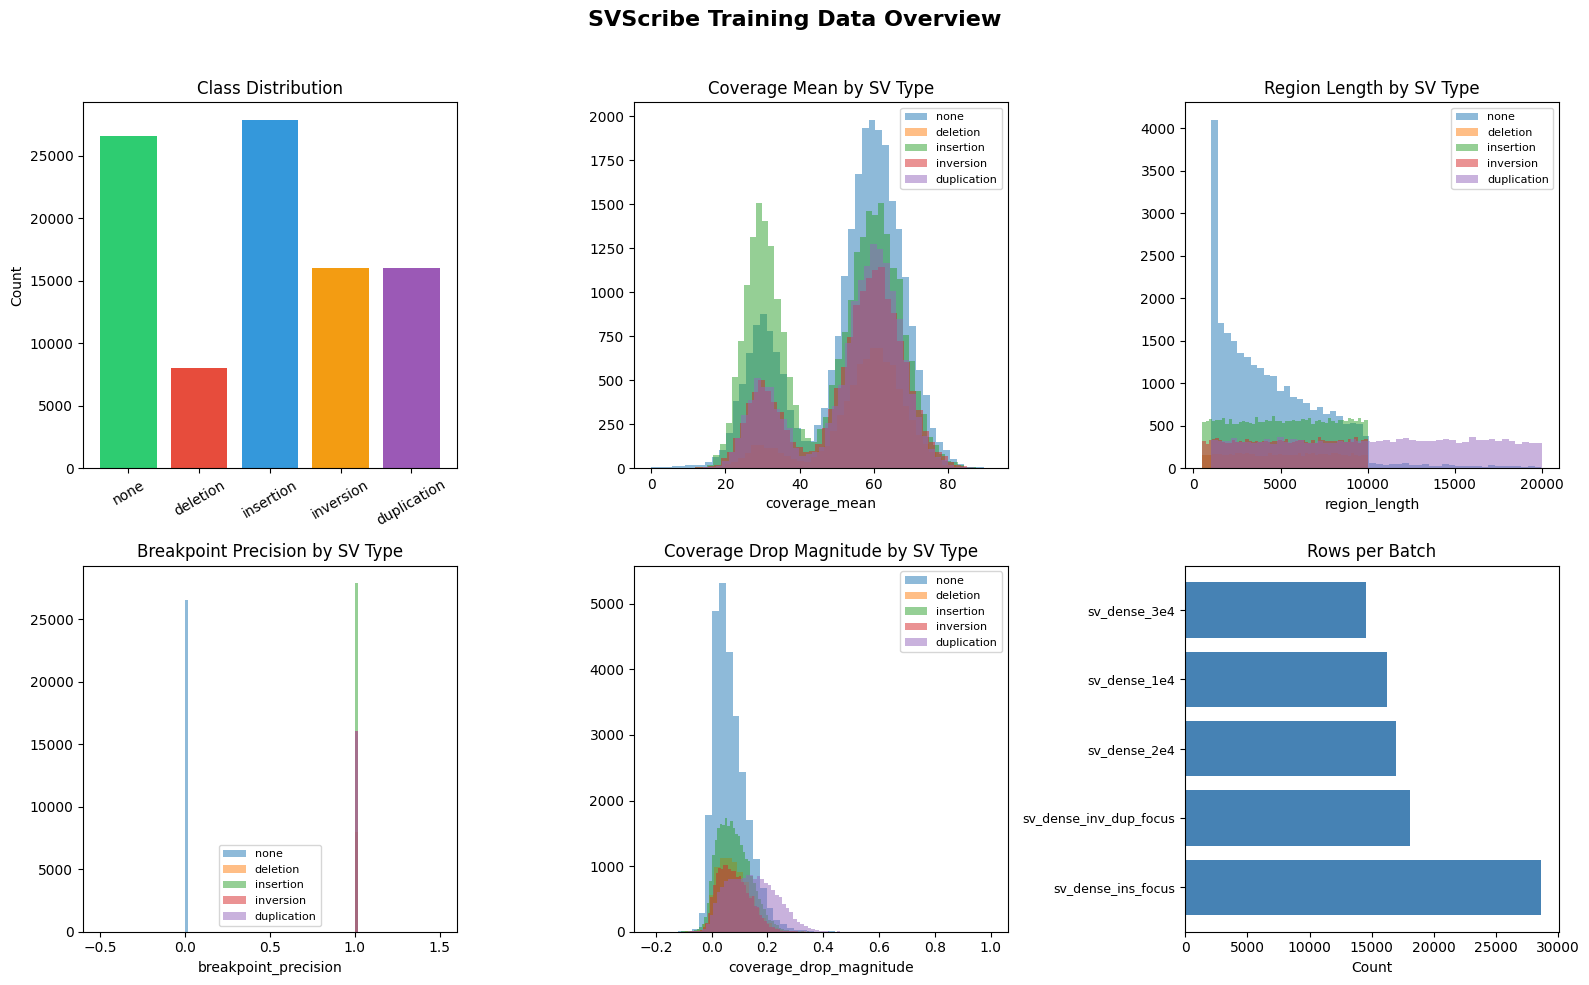

✓ Data overview plot saved


In [ ]:
# ── Visualize class balance and key feature distributions ───────────
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('SVScribe Training Data Overview', fontsize=16, fontweight='bold')

# 1. Class distribution
ax = axes[0, 0]
class_counts = df_all['sv_type_encoded'].value_counts().sort_index()
colors = ['#2ecc71', '#e74c3c', '#3498db', '#f39c12', '#9b59b6']
bars = ax.bar([SV_TYPE_NAMES[i] for i in class_counts.index], class_counts.values, color=colors)
ax.set_title('Class Distribution')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=30)

# 2. Coverage distribution by SV type
ax = axes[0, 1]
for sv_code in sorted(df_all['sv_type_encoded'].unique()):
    subset = df_all[df_all['sv_type_encoded'] == sv_code]['coverage_mean']
    ax.hist(subset, bins=50, alpha=0.5, label=SV_TYPE_NAMES[sv_code])
ax.set_title('Coverage Mean by SV Type')
ax.set_xlabel('coverage_mean')
ax.legend(fontsize=8)

# 3. Region length distribution
ax = axes[0, 2]
for sv_code in sorted(df_all['sv_type_encoded'].unique()):
    subset = df_all[df_all['sv_type_encoded'] == sv_code]['region_length']
    ax.hist(subset, bins=50, alpha=0.5, label=SV_TYPE_NAMES[sv_code])
ax.set_title('Region Length by SV Type')
ax.set_xlabel('region_length')
ax.legend(fontsize=8)

# 4. Breakpoint clustering (v3: replaces breakpoint_precision)
ax = axes[1, 0]
bp_col = 'breakpoint_clustering' if 'breakpoint_clustering' in df_all.columns else 'breakpoint_precision'
for sv_code in sorted(df_all['sv_type_encoded'].unique()):
    subset = df_all[df_all['sv_type_encoded'] == sv_code][bp_col]
    ax.hist(subset, bins=50, alpha=0.5, label=SV_TYPE_NAMES[sv_code])
ax.set_title(f'{bp_col} by SV Type')
ax.set_xlabel(bp_col)
ax.legend(fontsize=8)

# 5. Coverage drop magnitude
ax = axes[1, 1]
for sv_code in sorted(df_all['sv_type_encoded'].unique()):
    subset = df_all[df_all['sv_type_encoded'] == sv_code]['coverage_drop_magnitude']
    ax.hist(subset, bins=50, alpha=0.5, label=SV_TYPE_NAMES[sv_code])
ax.set_title('Coverage Drop Magnitude by SV Type')
ax.set_xlabel('coverage_drop_magnitude')
ax.legend(fontsize=8)

# 6. Batch distribution
ax = axes[1, 2]
batch_cts = df_all['batch'].value_counts()
ax.barh(range(len(batch_cts)), batch_cts.values, color='steelblue')
ax.set_yticks(range(len(batch_cts)))
ax.set_yticklabels(batch_cts.index, fontsize=9)
ax.set_title('Rows per Batch')
ax.set_xlabel('Count')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(os.path.join(SVSCRIBE_OUT, 'sv_data_overview.png'), dpi=150, bbox_inches='tight')
plt.show()
print("✓ Data overview plot saved")

In [ ]:
# ── v3.1 DIAGNOSTIC: Per-type feature distributions (SV-only) ───────
# Are the SV-specific signal features actually discriminative across types?
# This checks whether the model HAS signal to work with once metadata is removed.

sv_df = df_all[df_all['is_sv'] == 1].copy()
sv_df['subtype_name'] = sv_df['subtype_encoded'].map(SUBTYPE_NAMES)

# Key discriminative features to examine
diag_features = [
    'coverage_drop_magnitude',  # +ve = deletion, -ve = duplication
    'orientation_switch_rate',  # high = inversion
    'depth_ratio_flank',        # asymmetry → insertion/duplication
    'split_read_count',         # breakpoint reads
    'clip_fraction',            # soft-clipping → insertions
    'cov_drop_indicator',       # v3.1: explicit deletion signal
    'cov_gain_indicator',       # v3.1: explicit duplication signal
    'strand_switch_density',    # v3.1: explicit inversion signal
    'clip_split_signal',        # v3.1: explicit insertion signal
]
# Only include features that exist
diag_features = [f for f in diag_features if f in sv_df.columns]

n_feats = len(diag_features)
n_cols = 3
n_rows = (n_feats + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
fig.suptitle('v3.1 Diagnostic: SV Signal Features by Subtype\n'
             '(Do these features actually discriminate SV types?)',
             fontsize=14, fontweight='bold')

colors_4 = {'deletion': '#e74c3c', 'insertion': '#3498db',
            'inversion': '#f39c12', 'duplication': '#9b59b6'}

for idx, feat in enumerate(diag_features):
    row, col = idx // n_cols, idx % n_cols
    ax = axes[row, col] if n_rows > 1 else axes[col]

    for sv_name in ['deletion', 'insertion', 'inversion', 'duplication']:
        subset = sv_df[sv_df['subtype_name'] == sv_name][feat].dropna()
        ax.hist(subset, bins=50, alpha=0.45, label=sv_name, color=colors_4[sv_name])

    ax.set_title(feat, fontsize=10, fontweight='bold')
    ax.set_xlabel(feat, fontsize=8)
    ax.legend(fontsize=7)

# Hide empty subplots
for idx in range(n_feats, n_rows * n_cols):
    row, col = idx // n_cols, idx % n_cols
    ax = axes[row, col] if n_rows > 1 else axes[col]
    ax.set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.savefig(os.path.join(SVSCRIBE_OUT, 'sv_feature_diagnostic_v3.1.png'), dpi=150, bbox_inches='tight')
plt.show()

# Summary stats per type for key features
print("\nPer-type feature means (SV-only):")
print(f"{'Feature':<28s}  {'Deletion':>10s}  {'Insertion':>10s}  {'Inversion':>10s}  {'Duplication':>10s}")
print('─' * 75)
for feat in diag_features:
    vals = []
    for sv_name in ['deletion', 'insertion', 'inversion', 'duplication']:
        m = sv_df[sv_df['subtype_name'] == sv_name][feat].mean()
        vals.append(f"{m:10.4f}")
    print(f"{feat:<28s}  {'  '.join(vals)}")

print("\n✓ Diagnostic: if features show different distributions per type, the model has signal to learn.")

## 4b. DATA AUDIT — Is the Signal Actually There?

Before training, verify whether the S2 features can actually separate the 4 SV types.

1. **ANOVA F-statistics**: Rank every feature by discriminative power across the 4 types
2. **UMAP**: 2-D projection colored by SV type — do clusters form?
3. **Pairwise confusion heatmap**: Train a quick XGBoost and show which types get confused
4. **Feature overlap score**: For each type pair, fraction of feature-space overlap

In [ ]:
# ══════════════════════════════════════════════════════════════════════
#  DATA AUDIT: Can the features separate the 4 SV types?
# ══════════════════════════════════════════════════════════════════════
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import f_oneway
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, f1_score
import xgboost as xgb

sv_df = df_all[df_all['is_sv'] == 1].copy()
X_audit = sv_df[S2_FEATURES_CLEAN].fillna(0).values
y_audit = sv_df['subtype_encoded'].astype(int).values
feat_names = S2_FEATURES_CLEAN

print(f"Data audit: {X_audit.shape[0]:,} SV samples × {X_audit.shape[1]} features")
print(f"Class distribution: { {SUBTYPE_NAMES[c]: int(n) for c, n in zip(*np.unique(y_audit, return_counts=True))} }")

# ── 1. ANOVA F-statistics ───────────────────────────────────────────
print(f"\n{'═'*65}")
print("1. ANOVA F-STATISTICS  (higher = more discriminative)")
print(f"{'═'*65}")

groups = [X_audit[y_audit == c] for c in range(4)]
f_stats, p_vals = [], []
for j in range(X_audit.shape[1]):
    cols = [g[:, j] for g in groups]
    f, p = f_oneway(*cols)
    f_stats.append(f)
    p_vals.append(p)

f_stats = np.array(f_stats)
p_vals = np.array(p_vals)
rank_idx = np.argsort(f_stats)[::-1]

print(f"\n{'Rank':<5s} {'Feature':<30s} {'F-stat':>10s} {'p-value':>12s} {'Signal?':>8s}")
print('─' * 70)
for i, idx in enumerate(rank_idx):
    sig = '✓ YES' if p_vals[idx] < 1e-10 else ('~ weak' if p_vals[idx] < 0.01 else '✗ NO')
    print(f"{i+1:<5d} {feat_names[idx]:<30s} {f_stats[idx]:>10.1f} {p_vals[idx]:>12.2e} {sig:>8s}")

n_strong = (p_vals < 1e-10).sum()
n_weak = ((p_vals >= 1e-10) & (p_vals < 0.01)).sum()
n_none = (p_vals >= 0.01).sum()
print(f"\nSummary: {n_strong} strong + {n_weak} weak + {n_none} non-discriminative = {len(feat_names)} total")

# ── 2. UMAP visualization ──────────────────────────────────────────
print(f"\n{'═'*65}")
print("2. UMAP PROJECTION")
print(f"{'═'*65}")

try:
    import umap
    HAS_UMAP = True
except ImportError:
    print("  Installing umap-learn...")
    import subprocess, sys
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'umap-learn', '-q'])
    import umap
    HAS_UMAP = True

scaler_audit = StandardScaler()
X_scaled = scaler_audit.fit_transform(X_audit)

# Subsample for speed if > 20k
MAX_UMAP = 20000
if len(X_scaled) > MAX_UMAP:
    rng = np.random.RandomState(42)
    sub_idx = rng.choice(len(X_scaled), MAX_UMAP, replace=False)
    X_umap_in = X_scaled[sub_idx]
    y_umap_in = y_audit[sub_idx]
    print(f"  Subsampled to {MAX_UMAP:,} for UMAP")
else:
    X_umap_in = X_scaled
    y_umap_in = y_audit

reducer = umap.UMAP(n_neighbors=30, min_dist=0.3, metric='euclidean', random_state=42)
embedding = reducer.fit_transform(X_umap_in)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Left: colored by SV type
ax = axes[0]
colors_map = {0: '#e74c3c', 1: '#3498db', 2: '#f39c12', 3: '#9b59b6'}
for c in range(4):
    mask = y_umap_in == c
    ax.scatter(embedding[mask, 0], embedding[mask, 1],
               c=colors_map[c], label=SUBTYPE_NAMES[c],
               alpha=0.3, s=5, rasterized=True)
ax.set_title('UMAP — Colored by SV Type', fontsize=13, fontweight='bold')
ax.legend(markerscale=4, fontsize=10)
ax.set_xlabel('UMAP-1')
ax.set_ylabel('UMAP-2')

# Right: density per type (KDE contours)
ax = axes[1]
for c in range(4):
    mask = y_umap_in == c
    if mask.sum() > 50:
        try:
            ax.tricontour(embedding[mask, 0], embedding[mask, 1],
                          np.ones(mask.sum()), colors=[colors_map[c]], alpha=0.5)
        except Exception:
            pass
    ax.scatter(embedding[mask, 0], embedding[mask, 1],
               c=colors_map[c], label=SUBTYPE_NAMES[c],
               alpha=0.15, s=3, rasterized=True)
ax.set_title('UMAP — Density Overlap Check', fontsize=13, fontweight='bold')
ax.legend(markerscale=4, fontsize=10)
ax.set_xlabel('UMAP-1')
ax.set_ylabel('UMAP-2')

plt.tight_layout()
plt.savefig(os.path.join(SVSCRIBE_OUT, 'data_audit_umap.png'), dpi=150, bbox_inches='tight')
plt.show()

# ── 3. Quick OOF confusion matrix ──────────────────────────────────
print(f"\n{'═'*65}")
print("3. OOF CONFUSION MATRIX (quick 5-fold XGBoost)")
print(f"{'═'*65}")

# Use default XGBoost params for a quick diagnostic
quick_params = {
    'max_depth': 6, 'learning_rate': 0.1, 'n_estimators': 300,
    'objective': 'multi:softprob', 'num_class': 4,
    'eval_metric': 'mlogloss', 'random_state': 42,
    'tree_method': XGB_TREE, 'device': XGB_DEVICE,
}

oof_preds = np.full(len(y_audit), -1, dtype=int)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (tr_idx, va_idx) in enumerate(skf.split(X_scaled, y_audit)):
    m = xgb.XGBClassifier(**quick_params)
    m.fit(X_scaled[tr_idx], y_audit[tr_idx], verbose=False)
    oof_preds[va_idx] = m.predict(X_scaled[va_idx])

cm = confusion_matrix(y_audit, oof_preds, labels=[0, 1, 2, 3])
cm_pct = cm.astype(float) / cm.sum(axis=1, keepdims=True) * 100

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Raw counts
ax = axes[0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['DEL', 'INS', 'INV', 'DUP'],
            yticklabels=['DEL', 'INS', 'INV', 'DUP'], ax=ax)
ax.set_title('Confusion Matrix (counts)', fontsize=13, fontweight='bold')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')

# Percentage (row-normalized)
ax = axes[1]
sns.heatmap(cm_pct, annot=True, fmt='.1f', cmap='Oranges',
            xticklabels=['DEL', 'INS', 'INV', 'DUP'],
            yticklabels=['DEL', 'INS', 'INV', 'DUP'], ax=ax)
ax.set_title('Confusion Matrix (% of true class)', fontsize=13, fontweight='bold')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')

plt.suptitle('OOF Confusion — Where Does the Model Go Wrong?', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(SVSCRIBE_OUT, 'data_audit_confusion.png'), dpi=150, bbox_inches='tight')
plt.show()

# Print the key misclassification patterns
per_cls_f1 = f1_score(y_audit, oof_preds, average=None, labels=[0, 1, 2, 3])
print(f"\nOOF per-class F1 (no resampling, no weights, default HPs):")
for c in range(4):
    recall = cm_pct[c, c]
    # Top misclassification target
    row = cm_pct[c].copy()
    row[c] = 0  # exclude self
    worst_target = row.argmax()
    worst_pct = row[worst_target]
    print(f"  {SUBTYPE_NAMES[c]:12s}: F1={per_cls_f1[c]:.3f}  "
          f"Recall={recall:.1f}%  "
          f"Top confusion → {SUBTYPE_NAMES[worst_target]} ({worst_pct:.1f}%)")

print(f"\n  F1-macro: {per_cls_f1.mean():.3f}")
print(f"  min-F1:   {per_cls_f1.min():.3f}")

# ── 4. Feature overlap score (per-type-pair) ───────────────────────
print(f"\n{'═'*65}")
print("4. FEATURE OVERLAP MATRIX (Bhattacharyya distance)")
print(f"{'═'*65}")
print("  Higher distance = more separable. Low = heavily overlapping.")

def bhattacharyya_distance(x1, x2, n_bins=50):
    """Bhattacharyya distance between two 1-D distributions."""
    lo = min(x1.min(), x2.min())
    hi = max(x1.max(), x2.max())
    bins = np.linspace(lo, hi, n_bins + 1)
    h1, _ = np.histogram(x1, bins=bins, density=True)
    h2, _ = np.histogram(x2, bins=bins, density=True)
    h1 = h1 / (h1.sum() + 1e-12)
    h2 = h2 / (h2.sum() + 1e-12)
    bc = np.sum(np.sqrt(h1 * h2))
    return -np.log(bc + 1e-12)

# Compute mean Bhattacharyya distance across all features for each type pair
type_names = [SUBTYPE_NAMES[c] for c in range(4)]
dist_matrix = np.zeros((4, 4))
for i in range(4):
    for j in range(i + 1, 4):
        Xi = X_scaled[y_audit == i]
        Xj = X_scaled[y_audit == j]
        dists = []
        for f in range(X_scaled.shape[1]):
            d = bhattacharyya_distance(Xi[:, f], Xj[:, f])
            dists.append(d)
        mean_d = np.mean(dists)
        dist_matrix[i, j] = mean_d
        dist_matrix[j, i] = mean_d

fig, ax = plt.subplots(1, 1, figsize=(7, 6))
sns.heatmap(dist_matrix, annot=True, fmt='.3f', cmap='RdYlGn',
            xticklabels=type_names, yticklabels=type_names, ax=ax,
            vmin=0, vmax=dist_matrix.max())
ax.set_title('Mean Bhattacharyya Distance\n(higher = easier to separate)',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(SVSCRIBE_OUT, 'data_audit_overlap.png'), dpi=150, bbox_inches='tight')
plt.show()

# Print the hardest pairs
pairs = []
for i in range(4):
    for j in range(i + 1, 4):
        pairs.append((dist_matrix[i, j], type_names[i], type_names[j]))
pairs.sort()

print(f"\nType pairs ranked by separability (hardest → easiest):")
for d, n1, n2 in pairs:
    difficulty = '🔴 HARD' if d < 0.02 else ('🟡 MODERATE' if d < 0.05 else '🟢 EASY')
    print(f"  {n1:12s} vs {n2:12s}: {d:.4f}  {difficulty}")

# ── VERDICT ──────────────────────────────────────────────────────────
print(f"\n{'═'*65}")
print("AUDIT VERDICT")
print(f"{'═'*65}")
low_f = (f_stats[rank_idx] < 10).sum()
print(f"  Features with F < 10: {low_f}/{len(feat_names)}")
hard_pairs = sum(1 for d, _, _ in pairs if d < 0.02)
print(f"  Type pairs with dist < 0.02 (hard): {hard_pairs}/{len(pairs)}")
print(f"  Quick OOF min-F1 (no tricks): {per_cls_f1.min():.3f}")
print()
if per_cls_f1.min() < 0.60 and hard_pairs >= 2:
    print("  ⚠ DIAGNOSIS: Feature separation is weak for multiple type pairs.")
    print("    → The training data likely does not inject strong enough")
    print("      type-specific signatures. Fix the data generator first.")
    print("    → Model-side tricks (ensemble, thresholds) cannot compensate.")
elif per_cls_f1.min() < 0.65:
    print("  ⚠ DIAGNOSIS: Moderate separation exists but some pairs overlap.")
    print("    → Consider OVR classifiers or hierarchical cascade for the")
    print("      hardest pairs. Data improvements would also help.")
else:
    print("  ✓ Feature separation is reasonable. Model-side improvements")
    print("    (OVR, stacking, threshold tuning) should be sufficient.")

## 5. Train SVScribe — Two-Stage Architecture (v5)

**Stage 1 — Binary SV detector** (SV vs. background): Optuna HP search → XGBoost binary classifier. Uses equalized resampling + sample weights.

**Stage 2 — SV subtype classifier** (deletion / insertion / inversion / duplication): Optuna HP search for BOTH XGBoost and LightGBM → blend ensemble → per-class threshold optimization.

> v5 key changes from v4:
> - **Ensemble**: XGBoost + LightGBM with tuned blend weight (algorithmic diversity)
> - **Per-class thresholds**: Scaling factors fix inversion false-positive and duplication false-negative imbalance
> - **Removed**: Post-prediction bio calibration (α→0, confirmed ineffective) and bio-conditioned sample weights
> - **Retained**: Bio composite features as standard model inputs

In [ ]:
import time
import optuna
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from collections import Counter
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix,
    precision_recall_fscore_support,
)
import warnings
warnings.filterwarnings('ignore',
                        message='X does not have valid feature names')

optuna.logging.set_verbosity(optuna.logging.WARNING)
subtype_names_list = ['deletion', 'insertion', 'inversion', 'duplication']


# ── Resampling & weighting utilities ────────────────────────────────
def equalize_resample(X, y, random_state=42):
    """All classes to same count (p60 of raw sizes). Gaussian noise on oversampled rows."""
    classes, counts = np.unique(y, return_counts=True)
    target = int(np.percentile(counts, 60))
    print(f"    equalize target per class: {target:,}")
    rng = np.random.RandomState(random_state)

    X_parts, y_parts = [], []
    for cls in classes:
        mask = y == cls
        X_cls, y_cls = X[mask], y[mask]
        if len(X_cls) > target:
            idx = rng.choice(len(X_cls), target, replace=False)
            X_parts.append(X_cls[idx]); y_parts.append(y_cls[idx])
        elif len(X_cls) < target:
            X_parts.append(X_cls); y_parts.append(y_cls)
            need = target - len(X_cls)
            idx = rng.choice(len(X_cls), need, replace=True)
            X_over = X_cls[idx].copy()
            noise = rng.normal(0, 0.01 * (X_cls.std(axis=0) + 1e-8), X_over.shape)
            X_over += noise
            X_parts.append(X_over); y_parts.append(y_cls[idx])
        else:
            X_parts.append(X_cls); y_parts.append(y_cls)
    return np.vstack(X_parts), np.concatenate(y_parts)


def compute_sample_weights(y, boost_map=None):
    """Inverse-frequency weights + explicit boosts."""
    classes, counts = np.unique(y, return_counts=True)
    n_total, n_classes = len(y), len(classes)
    weight_map = {}
    for cls, cnt in zip(classes, counts):
        w = n_total / (n_classes * cnt)
        if boost_map and cls in boost_map:
            w *= boost_map[cls]
        weight_map[cls] = w
    return np.array([weight_map[yi] for yi in y])


# ── Optuna objectives ───────────────────────────────────────────────
def optuna_objective_xgb(trial, X, y, sample_w, n_classes, objective_fn='min_class_f1'):
    """XGBoost HP search."""
    params = {
        'max_depth': trial.suggest_int('max_depth', 4, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 200, 1200),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 15),
        'max_delta_step': trial.suggest_float('max_delta_step', 0, 5.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'gamma': trial.suggest_float('gamma', 0, 5.0),
        'tree_method': XGB_TREE,
        'device': XGB_DEVICE,
        'random_state': SEED,
        'objective': ('binary:logistic' if n_classes == 2 else 'multi:softprob'),
        'eval_metric': ('logloss' if n_classes == 2 else 'mlogloss'),
    }
    if n_classes > 2:
        params['num_class'] = n_classes

    model = xgb.XGBClassifier(**params)
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
    scores = []
    for train_idx, val_idx in skf.split(X, y):
        X_tr, X_va = X[train_idx], X[val_idx]
        y_tr, y_va = y[train_idx], y[val_idx]
        w_tr = sample_w[train_idx] if sample_w is not None else None
        model.fit(X_tr, y_tr, sample_weight=w_tr, verbose=False)
        y_pred = model.predict(X_va)
        if objective_fn == 'min_class_f1':
            per_cls = f1_score(y_va, y_pred, average=None, labels=list(range(n_classes)))
            scores.append(per_cls.min())
        elif objective_fn == 'f1_binary':
            scores.append(f1_score(y_va, y_pred, average='binary'))
        else:
            scores.append(f1_score(y_va, y_pred, average='macro'))
    return np.mean(scores)


def optuna_objective_lgbm(trial, X, y, sample_w, n_classes, objective_fn='min_class_f1'):
    """LightGBM HP search."""
    params = {
        'max_depth': trial.suggest_int('max_depth', 4, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 200, 1200),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 31, 255),
        'verbose': -1,
        'random_state': SEED,
        'objective': ('binary' if n_classes == 2 else 'multiclass'),
        'metric': ('binary_logloss' if n_classes == 2 else 'multi_logloss'),
    }
    if n_classes > 2:
        params['num_class'] = n_classes

    model = lgb.LGBMClassifier(**params)
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
    scores = []
    for train_idx, val_idx in skf.split(X, y):
        X_tr, X_va = X[train_idx], X[val_idx]
        y_tr, y_va = y[train_idx], y[val_idx]
        w_tr = sample_w[train_idx] if sample_w is not None else None
        model.fit(X_tr, y_tr, sample_weight=w_tr)
        y_pred = model.predict(X_va)
        if objective_fn == 'min_class_f1':
            per_cls = f1_score(y_va, y_pred, average=None, labels=list(range(n_classes)))
            scores.append(per_cls.min())
        elif objective_fn == 'f1_binary':
            scores.append(f1_score(y_va, y_pred, average='binary'))
        else:
            scores.append(f1_score(y_va, y_pred, average='macro'))
    return np.mean(scores)


# ── v5: Per-class threshold optimization ────────────────────────────
def optimize_class_thresholds(proba, y_true, n_classes=4, n_grid=40):
    """
    Find per-class scaling factors that maximize min-class F1.

    Instead of argmax(P), use argmax(P × scale_c) where each scale_c
    adjusts the effective decision threshold for that class.

    Uses coordinate-descent with iterative refinement.
    """
    best_scales = np.ones(n_classes, dtype=np.float64)
    y_pred = proba.argmax(axis=1)
    per_cls = f1_score(y_true, y_pred, average=None, labels=list(range(n_classes)))
    best_min_f1 = per_cls.min()

    for pass_num in range(4):
        radius = 2.0 / (pass_num + 1)
        improved = False
        for c in range(n_classes):
            center = best_scales[c]
            lo = max(0.05, center - radius)
            hi = center + radius
            for s in np.linspace(lo, hi, n_grid):
                scales = best_scales.copy()
                scales[c] = s
                adjusted = proba * scales[None, :]
                y_pred = adjusted.argmax(axis=1)
                per_cls = f1_score(y_true, y_pred, average=None,
                                   labels=list(range(n_classes)))
                min_f1 = per_cls.min()
                if min_f1 > best_min_f1 + 1e-5:
                    best_min_f1 = min_f1
                    best_scales = scales.copy()
                    improved = True
        if not improved:
            break

    return best_scales, best_min_f1


# ── Prepare feature matrices ───────────────────────────────────────
X_all = df_all[S1_FEATURES_CLEAN].fillna(0).values
y_binary = df_all['is_sv'].values
y_5class = df_all['sv_type_encoded'].values

sv_mask = y_binary == 1
X_sv_only_s2 = df_all.loc[sv_mask, S2_FEATURES_CLEAN].fillna(0).values
y_subtype = df_all.loc[sv_mask, 'subtype_encoded'].astype(int).values

print(f"Stage 1 features: {X_all.shape[1]} ({len(S1_FEATURES_CLEAN)} columns)")
print(f"Stage 2 features: {X_sv_only_s2.shape[1]} ({len(S2_FEATURES_CLEAN)} columns — NO metadata)")
print(f"Stage 1 data: {X_all.shape[0]:,} samples")
print(f"Stage 2 data: {X_sv_only_s2.shape[0]:,} SV samples (4-class)")

excluded = sorted(set(S1_FEATURES_CLEAN) - set(S2_FEATURES_CLEAN))
if excluded:
    print(f"\n  Features excluded from S2 (batch proxies): {excluded}")


# ══════════════════════════════════════════════════════════════════════
#  STAGE 1: Binary SV detector (XGBoost, unchanged)
# ══════════════════════════════════════════════════════════════════════
print(f"\n{'═'*60}")
print("STAGE 1: Binary SV Detector (SV vs. background)")
print(f"{'═'*60}")

X_s1, y_s1 = equalize_resample(X_all, y_binary)
scaler_s1 = StandardScaler().fit(X_s1)
X_s1_scaled = scaler_s1.transform(X_s1)
w_s1 = compute_sample_weights(y_s1)

print(f"  Balanced: {len(y_s1):,} samples, distribution: {dict(Counter(y_s1))}")

print(f"  Running Optuna ({N_OPTUNA_TRIALS_S1} trials, objective=f1_binary)...")
t0 = time.time()
study_s1 = optuna.create_study(direction='maximize')
study_s1.optimize(
    lambda trial: optuna_objective_xgb(trial, X_s1_scaled, y_s1, w_s1, 2, 'f1_binary'),
    n_trials=N_OPTUNA_TRIALS_S1, show_progress_bar=True)

s1_params = dict(study_s1.best_params)
s1_params.update({'tree_method': XGB_TREE, 'device': XGB_DEVICE,
                  'objective': 'binary:logistic', 'eval_metric': 'logloss',
                  'random_state': SEED})
print(f"  Best F1-binary: {study_s1.best_value:.4f} ({(time.time()-t0)/60:.1f} min)")

s1_model = xgb.XGBClassifier(**s1_params)
s1_model.fit(X_s1_scaled, y_s1, sample_weight=w_s1)
print(f"  ✓ Stage 1 model trained")


# ══════════════════════════════════════════════════════════════════════
#  STAGE 2: v5 XGBoost + LightGBM Ensemble + Threshold Tuning
# ══════════════════════════════════════════════════════════════════════
print(f"\n{'═'*60}")
print("STAGE 2: v5 XGBoost + LightGBM Ensemble")
print(f"  {len(S2_FEATURES_CLEAN)} signal+engineered features (no metadata)")
print(f"  XGBoost + LightGBM → blend → per-class threshold optimization")
print(f"{'═'*60}")

# Equalize & scale
X_s2, y_s2 = equalize_resample(X_sv_only_s2, y_subtype)
scaler_s2 = StandardScaler().fit(X_s2)
X_s2_scaled = scaler_s2.transform(X_s2)
w_s2 = compute_sample_weights(y_s2, boost_map={0: 1.5, 2: 1.3})

print(f"  Balanced: {len(y_s2):,} samples, distribution: {dict(Counter(y_s2))}")

# ── Tune XGBoost S2 ─────────────────────────────────────────────
print(f"\n  ═ XGBoost HP search ({N_OPTUNA_TRIALS_S2} trials)...")
t0 = time.time()
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(
    lambda trial: optuna_objective_xgb(trial, X_s2_scaled, y_s2, w_s2, 4),
    n_trials=N_OPTUNA_TRIALS_S2, show_progress_bar=True)

s2_xgb_params = dict(study_xgb.best_params)
s2_xgb_params.update({'tree_method': XGB_TREE, 'device': XGB_DEVICE,
                       'objective': 'multi:softprob', 'num_class': 4,
                       'eval_metric': 'mlogloss', 'random_state': SEED})
print(f"    Best min-class-F1: {study_xgb.best_value:.4f} ({(time.time()-t0)/60:.1f} min)")

# ── Tune LightGBM S2 ────────────────────────────────────────────
print(f"\n  ═ LightGBM HP search ({N_OPTUNA_TRIALS_S2} trials)...")
t0 = time.time()
study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(
    lambda trial: optuna_objective_lgbm(trial, X_s2_scaled, y_s2, w_s2, 4),
    n_trials=N_OPTUNA_TRIALS_S2, show_progress_bar=True)

s2_lgbm_params = dict(study_lgbm.best_params)
s2_lgbm_params.update({'verbose': -1, 'random_state': SEED,
                        'objective': 'multiclass', 'num_class': 4,
                        'metric': 'multi_logloss'})
print(f"    Best min-class-F1: {study_lgbm.best_value:.4f} ({(time.time()-t0)/60:.1f} min)")

# ── Train final S2 models ────────────────────────────────────────
s2_model_xgb = xgb.XGBClassifier(**s2_xgb_params)
s2_model_xgb.fit(X_s2_scaled, y_s2, sample_weight=w_s2)

s2_model_lgbm = lgb.LGBMClassifier(**s2_lgbm_params)
s2_model_lgbm.fit(X_s2_scaled, y_s2, sample_weight=w_s2)

print(f"\n  ✓ Both S2 models trained (XGBoost + LightGBM)")

# ── Tune blend weight + per-class thresholds via OOF ─────────────
print(f"\n  ═ Tuning ensemble blend weight + per-class thresholds (OOF)...")
oof_proba_xgb = np.zeros((len(y_s2), 4))
oof_proba_lgbm = np.zeros((len(y_s2), 4))

skf_oof = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
for fold, (tr_idx, va_idx) in enumerate(skf_oof.split(X_s2_scaled, y_s2)):
    m_xgb = xgb.XGBClassifier(**s2_xgb_params)
    m_xgb.fit(X_s2_scaled[tr_idx], y_s2[tr_idx],
              sample_weight=w_s2[tr_idx], verbose=False)
    oof_proba_xgb[va_idx] = m_xgb.predict_proba(X_s2_scaled[va_idx])

    m_lgbm = lgb.LGBMClassifier(**s2_lgbm_params)
    m_lgbm.fit(X_s2_scaled[tr_idx], y_s2[tr_idx],
               sample_weight=w_s2[tr_idx])
    oof_proba_lgbm[va_idx] = m_lgbm.predict_proba(X_s2_scaled[va_idx])

# Optimize blend weight
best_blend_w, best_blend_f1 = 0.5, 0.0
for w in np.linspace(0.1, 0.9, 17):
    blended = w * oof_proba_xgb + (1 - w) * oof_proba_lgbm
    y_pred = blended.argmax(axis=1)
    per_cls = f1_score(y_s2, y_pred, average=None, labels=list(range(4)))
    mf1 = per_cls.min()
    if mf1 > best_blend_f1:
        best_blend_f1 = mf1
        best_blend_w = w

print(f"    Blend weight: XGBoost={best_blend_w:.2f}, LightGBM={1-best_blend_w:.2f}")

# Baselines
oof_blended = best_blend_w * oof_proba_xgb + (1 - best_blend_w) * oof_proba_lgbm
baseline_pred = oof_blended.argmax(axis=1)
baseline_per_cls = f1_score(y_s2, baseline_pred, average=None, labels=list(range(4)))
print(f"    Baseline min-F1 (blend, no thresholds): {baseline_per_cls.min():.4f}")
print(f"    Baseline per-class: {', '.join(f'{n}={f:.3f}' for n, f in zip(subtype_names_list, baseline_per_cls))}")

# Optimize per-class thresholds
class_scales, threshold_min_f1 = optimize_class_thresholds(oof_blended, y_s2)

print(f"\n    Per-class threshold scales:")
for c, name in enumerate(subtype_names_list):
    print(f"      {name}: {class_scales[c]:.3f}")

thresh_pred = (oof_blended * class_scales[None, :]).argmax(axis=1)
thresh_per_cls = f1_score(y_s2, thresh_pred, average=None, labels=list(range(4)))
print(f"\n    Threshold-tuned min-F1 (OOF): {threshold_min_f1:.4f}")
print(f"    Threshold-tuned per-class: {', '.join(f'{n}={f:.3f}' for n, f in zip(subtype_names_list, thresh_per_cls))}")
delta_min = threshold_min_f1 - baseline_per_cls.min()
print(f"    🔧 Threshold improvement: Δmin-F1 = {delta_min:+.4f}")

print(f"\n✅ Both stages complete.")

Raw data: 94,458 samples × 33 features
Class distribution: {np.int64(2): 27860, np.int64(3): 16012, np.int64(1): 8001, np.int64(4): 16032, np.int64(0): 26553}

After hybrid resampling: 102,509 samples
Balanced distribution:  {np.int64(0): 26553, np.int64(1): 16032, np.int64(2): 27860, np.int64(3): 16032, np.int64(4): 16032}

Running Optuna (30 trials)...


  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/xgboost/core.py:751: UserWarning: [18:50:42] WARNING: /__w/xgboost/xgboost/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)



Best F1-macro: 0.7965 (4.7 min)
Best params: depth=8, lr=0.1017, n_est=629


Running 5-fold CV...
  Fold 1: Accuracy=0.8316, F1-macro=0.8079
  Fold 2: Accuracy=0.8315, F1-macro=0.8089
  Fold 3: Accuracy=0.8317, F1-macro=0.8075
  Fold 4: Accuracy=0.8320, F1-macro=0.8078
  Fold 5: Accuracy=0.8311, F1-macro=0.8069

CV Summary: Accuracy=0.8316±0.0003, F1-macro=0.8078±0.0006

Training final model on all 102,509 samples...

✓ Saved: /content/trained_models/sv_detector/sv_detector_model.pkl

════════════════════════════════════════════════════════════
Classification Report (last CV fold):
════════════════════════════════════════════════════════════
              precision    recall  f1-score   support

        none      1.000     1.000     1.000      5310
    deletion      0.658     0.902     0.761      3207
   insertion      0.876     0.810     0.842      5572
   inversion      0.697     0.760     0.727      3206
 duplication      0.880     0.589     0.705      3206

    accuracy                          0.831     20501
   macro avg      0.822     0.812     0.807    

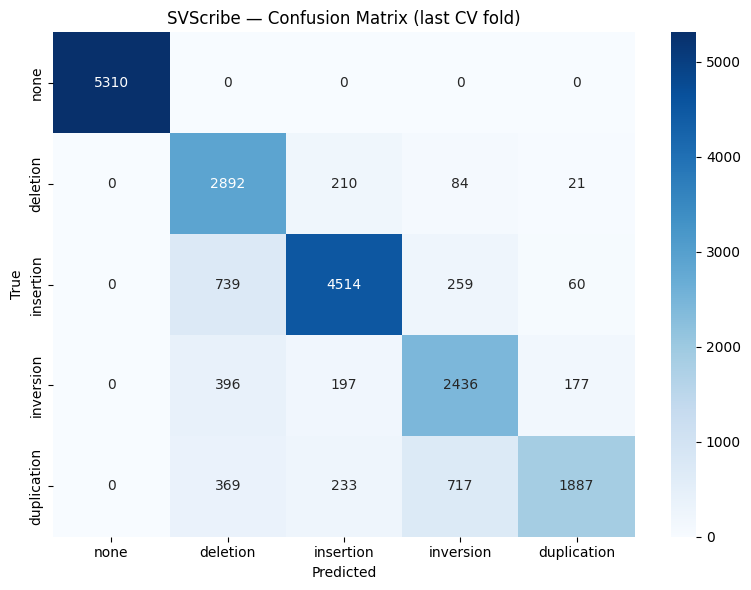

✓ Training results saved


In [ ]:
# ══════════════════════════════════════════════════════════════════════
#  v5: TWO-STAGE CROSS-VALIDATION + SAVE
# ══════════════════════════════════════════════════════════════════════

# ── Stage 1 CV ──────────────────────────────────────────────────────
print(f"{'═'*60}")
print(f"Stage 1 — {N_CV_FOLDS}-fold CV (binary, {len(S1_FEATURES_CLEAN)} features)")
print(f"{'═'*60}")

skf1 = StratifiedKFold(n_splits=N_CV_FOLDS, shuffle=True, random_state=SEED)
s1_cv_acc, s1_cv_f1 = [], []

for fold, (tr_idx, va_idx) in enumerate(skf1.split(X_s1_scaled, y_s1)):
    X_tr, X_va = X_s1_scaled[tr_idx], X_s1_scaled[va_idx]
    y_tr, y_va = y_s1[tr_idx], y_s1[va_idx]
    w_tr = w_s1[tr_idx]
    m = xgb.XGBClassifier(**s1_params)
    m.fit(X_tr, y_tr, sample_weight=w_tr, eval_set=[(X_va, y_va)], verbose=False)
    y_pred = m.predict(X_va)
    acc = accuracy_score(y_va, y_pred)
    f1 = f1_score(y_va, y_pred, average='binary')
    s1_cv_acc.append(acc); s1_cv_f1.append(f1)
    print(f"  Fold {fold+1}: Acc={acc:.4f}, F1={f1:.4f}")

print(f"  CV: Acc={np.mean(s1_cv_acc):.4f}±{np.std(s1_cv_acc):.4f}, "
      f"F1={np.mean(s1_cv_f1):.4f}±{np.std(s1_cv_f1):.4f}")


# ── Stage 2 CV (v5: ensemble + per-fold threshold tuning) ───────────
print(f"\n{'═'*60}")
print(f"Stage 2 — {N_CV_FOLDS}-fold CV (4-class, ensemble + thresholds)")
print(f"  XGBoost + LightGBM blend (w={best_blend_w:.2f})")
print(f"  Per-class thresholds tuned per fold (non-leaky)")
print(f"{'═'*60}")

skf2 = StratifiedKFold(n_splits=N_CV_FOLDS, shuffle=True, random_state=SEED)

# XGBoost-only baseline
s2_cv_f1_macro_xgb, s2_cv_min_f1_xgb = [], []
s2_per_cls_f1_xgb = {c: [] for c in range(4)}

# Blended (no thresholds)
s2_cv_f1_macro_blend, s2_cv_min_f1_blend = [], []
s2_per_cls_f1_blend = {c: [] for c in range(4)}

# Full v5: blend + thresholds
s2_cv_acc, s2_cv_f1_macro, s2_cv_min_f1 = [], [], []
s2_per_cls_f1 = {c: [] for c in range(4)}
s2_per_cls_prec = {c: [] for c in range(4)}
s2_per_cls_rec = {c: [] for c in range(4)}
cv_scales_list = []

for fold, (tr_idx, va_idx) in enumerate(skf2.split(X_s2_scaled, y_s2)):
    X_tr, X_va = X_s2_scaled[tr_idx], X_s2_scaled[va_idx]
    y_tr, y_va = y_s2[tr_idx], y_s2[va_idx]
    w_tr = w_s2[tr_idx]

    # Split training → model-train (80%) + threshold-tune (20%)
    tr_model, tr_tune = train_test_split(
        np.arange(len(y_tr)), test_size=0.2,
        stratify=y_tr, random_state=SEED + fold)
    X_model, y_model, w_model = X_tr[tr_model], y_tr[tr_model], w_tr[tr_model]
    X_tune, y_tune = X_tr[tr_tune], y_tr[tr_tune]

    # Train both models on model-train split
    m_xgb = xgb.XGBClassifier(**s2_xgb_params)
    m_xgb.fit(X_model, y_model, sample_weight=w_model, verbose=False)

    m_lgbm = lgb.LGBMClassifier(**s2_lgbm_params)
    m_lgbm.fit(X_model, y_model, sample_weight=w_model)

    # ── XGBoost-only baseline ────────────────────────────────
    y_pred_xgb = m_xgb.predict(X_va)
    per_cls_xgb = f1_score(y_va, y_pred_xgb, average=None, labels=list(range(4)))
    s2_cv_f1_macro_xgb.append(f1_score(y_va, y_pred_xgb, average='macro'))
    s2_cv_min_f1_xgb.append(per_cls_xgb.min())
    for c in range(4):
        s2_per_cls_f1_xgb[c].append(per_cls_xgb[c])

    # ── Blended ensemble (no thresholds) ─────────────────────
    blend_proba_va = (best_blend_w * m_xgb.predict_proba(X_va) +
                      (1 - best_blend_w) * m_lgbm.predict_proba(X_va))
    y_pred_blend = blend_proba_va.argmax(axis=1)
    per_cls_blend = f1_score(y_va, y_pred_blend, average=None, labels=list(range(4)))
    s2_cv_f1_macro_blend.append(f1_score(y_va, y_pred_blend, average='macro'))
    s2_cv_min_f1_blend.append(per_cls_blend.min())
    for c in range(4):
        s2_per_cls_f1_blend[c].append(per_cls_blend[c])

    # ── Per-class threshold tuning on tune split ─────────────
    tune_proba = (best_blend_w * m_xgb.predict_proba(X_tune) +
                  (1 - best_blend_w) * m_lgbm.predict_proba(X_tune))
    fold_scales, _ = optimize_class_thresholds(tune_proba, y_tune)
    cv_scales_list.append(fold_scales)

    # ── Evaluate with thresholds on validation ───────────────
    adjusted_proba = blend_proba_va * fold_scales[None, :]
    y_pred = adjusted_proba.argmax(axis=1)

    acc = accuracy_score(y_va, y_pred)
    f1_macro = f1_score(y_va, y_pred, average='macro')
    per_cls = f1_score(y_va, y_pred, average=None, labels=list(range(4)))
    prec_arr, rec_arr, _, _ = precision_recall_fscore_support(
        y_va, y_pred, labels=list(range(4)))
    min_f1 = per_cls.min()

    s2_cv_acc.append(acc)
    s2_cv_f1_macro.append(f1_macro)
    s2_cv_min_f1.append(min_f1)
    for c in range(4):
        s2_per_cls_f1[c].append(per_cls[c])
        s2_per_cls_prec[c].append(prec_arr[c])
        s2_per_cls_rec[c].append(rec_arr[c])

    cls_str = "  ".join(f"{subtype_names_list[c]}={per_cls[c]:.3f}" for c in range(4))
    print(f"  Fold {fold+1}: F1-macro={f1_macro:.4f}, min-F1={min_f1:.4f}")
    print(f"           {cls_str}")
    print(f"           scales=[{', '.join(f'{s:.2f}' for s in fold_scales)}]")

# ── v5 improvement summary ──────────────────────────────────────
print(f"\n{'═'*60}")
print("Stage 2 — Results Comparison")
print(f"{'═'*60}")
print(f"  XGBoost only:        F1-macro={np.mean(s2_cv_f1_macro_xgb):.4f}±{np.std(s2_cv_f1_macro_xgb):.4f}, "
      f"min-F1={np.mean(s2_cv_min_f1_xgb):.4f}±{np.std(s2_cv_min_f1_xgb):.4f}")
print(f"  + LightGBM blend:    F1-macro={np.mean(s2_cv_f1_macro_blend):.4f}±{np.std(s2_cv_f1_macro_blend):.4f}, "
      f"min-F1={np.mean(s2_cv_min_f1_blend):.4f}±{np.std(s2_cv_min_f1_blend):.4f}")
print(f"  + class thresholds:  F1-macro={np.mean(s2_cv_f1_macro):.4f}±{np.std(s2_cv_f1_macro):.4f}, "
      f"min-F1={np.mean(s2_cv_min_f1):.4f}±{np.std(s2_cv_min_f1):.4f}")

delta_blend = np.mean(s2_cv_min_f1_blend) - np.mean(s2_cv_min_f1_xgb)
delta_thresh = np.mean(s2_cv_min_f1) - np.mean(s2_cv_min_f1_blend)
delta_total = np.mean(s2_cv_min_f1) - np.mean(s2_cv_min_f1_xgb)

print(f"\n  🔧 Improvements over XGBoost-only:")
print(f"    + LightGBM blend:      Δmin-F1 = {delta_blend:+.4f}")
print(f"    + class thresholds:    Δmin-F1 = {delta_thresh:+.4f}")
print(f"    Total:                 Δmin-F1 = {delta_total:+.4f}")

# Per-type breakdown
print(f"\n  Per-class F1 (v5 ensemble + thresholds):")
print(f"  {'SV Type':<15}  {'F1':>12}  {'P':>12}  {'R':>12}  {'Δ vs XGB':>10}")
print('  ' + '─' * 65)
for c in range(4):
    f1_v5 = np.mean(s2_per_cls_f1[c])
    f1_xgb_only = np.mean(s2_per_cls_f1_xgb[c])
    delta = f1_v5 - f1_xgb_only
    p = np.mean(s2_per_cls_prec[c])
    r = np.mean(s2_per_cls_rec[c])
    print(f"  {subtype_names_list[c]:<15}  "
          f"{f1_v5:.3f}±{np.std(s2_per_cls_f1[c]):.3f}  "
          f"{p:.3f}±{np.std(s2_per_cls_prec[c]):.3f}  "
          f"{r:.3f}±{np.std(s2_per_cls_rec[c]):.3f}  "
          f"{delta:+.3f}")

# ── Classification report (last fold) ──────────────────────────
print(f"\n{'═'*60}")
print("Stage 2 Classification Report (last fold, v5 ensemble):")
print(f"{'═'*60}")
print(classification_report(y_va, y_pred, target_names=subtype_names_list, digits=3))

# ── Confusion matrices ──────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('SVScribe v5 — Two-Stage Confusion Matrices (last CV fold)',
             fontsize=14, fontweight='bold')

s1_pred_last = s1_model.predict(X_s1_scaled[va_idx[:min(len(va_idx), 5000)]])
y_s1_va = y_s1[va_idx[:min(len(va_idx), 5000)]]
cm1 = confusion_matrix(y_s1_va, s1_pred_last)
ax = axes[0]
sns.heatmap(cm1, annot=True, fmt='d', cmap='Greens',
            xticklabels=['background', 'SV'], yticklabels=['background', 'SV'], ax=ax)
ax.set_xlabel('Predicted'); ax.set_ylabel('True')
ax.set_title('Stage 1: SV vs Background')

cm2 = confusion_matrix(y_va, y_pred)
ax = axes[1]
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues',
            xticklabels=subtype_names_list, yticklabels=subtype_names_list, ax=ax)
ax.set_xlabel('Predicted'); ax.set_ylabel('True')
ax.set_title('Stage 2: SV Subtype (ensemble + thresholds)')

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.savefig(os.path.join(SVSCRIBE_OUT, 'sv_confusion_matrices_v5.png'), dpi=150, bbox_inches='tight')
plt.show()

# ── Save models ─────────────────────────────────────────────────
sv_model_dir = os.path.join(MODELS_OUT, 'sv_detector')
os.makedirs(sv_model_dir, exist_ok=True)

# Stage 1 bundle
s1_bundle = {
    'model': s1_model,
    'scaler': scaler_s1,
    'feature_columns': S1_FEATURES_CLEAN,
}
with open(os.path.join(sv_model_dir, 'sv_binary_model.pkl'), 'wb') as f:
    pickle.dump(s1_bundle, f)
print(f"✓ Saved: sv_binary_model.pkl ({len(S1_FEATURES_CLEAN)} features)")

# Stage 2 bundle (v5: XGBoost + LightGBM ensemble)
subtype_le = LabelEncoder()
subtype_le.classes_ = np.array(subtype_names_list)
s2_bundle = {
    'model_xgb': s2_model_xgb,
    'model_lgbm': s2_model_lgbm,
    'scaler': scaler_s2,
    'label_encoder': subtype_le,
    'feature_columns': S2_FEATURES_CLEAN,
    'blend_weight': float(best_blend_w),
    'class_scales': class_scales.tolist(),
}
with open(os.path.join(sv_model_dir, 'sv_subtype_model.pkl'), 'wb') as f:
    pickle.dump(s2_bundle, f)
print(f"✓ Saved: sv_subtype_model.pkl ({len(S2_FEATURES_CLEAN)} features, "
      f"blend_w={best_blend_w:.2f}, "
      f"scales=[{', '.join(f'{s:.2f}' for s in class_scales)}])")

# 5-class fallback (for backwards compat)
X_5c_all = df_all[S1_FEATURES_CLEAN].fillna(0).values
X_5c, y_5c = equalize_resample(X_5c_all, y_5class)
scaler_5c = StandardScaler().fit(X_5c)
X_5c_scaled = scaler_5c.transform(X_5c)
w_5c = compute_sample_weights(y_5c, boost_map={1: 1.5, 3: 1.3})
fallback_params = dict(s2_xgb_params)
fallback_params['num_class'] = 5
fallback_model = xgb.XGBClassifier(**fallback_params)
fallback_model.fit(X_5c_scaled, y_5c, sample_weight=w_5c)
with open(os.path.join(sv_model_dir, 'sv_detector_model.pkl'), 'wb') as f:
    pickle.dump(fallback_model, f)
print(f"✓ Saved: sv_detector_model.pkl (5-class fallback)")

# ── Training results JSON ───────────────────────────────────────
sv_results = {
    'training_version': 'v5',
    'architecture': 'two_stage_xgb_lgbm_ensemble_with_threshold_tuning',
    'stage1': {
        'task': 'binary (SV vs background)',
        'n_features': len(S1_FEATURES_CLEAN),
        'feature_set': 'metadata + signal + engineered',
        'best_params': {k: v for k, v in s1_params.items() if k != 'device'},
        'cv_accuracy_mean': float(np.mean(s1_cv_acc)),
        'cv_f1_binary_mean': float(np.mean(s1_cv_f1)),
    },
    'stage2': {
        'task': '4-class subtype (del/ins/inv/dup)',
        'n_features': len(S2_FEATURES_CLEAN),
        'feature_set': 'signal + engineered ONLY (metadata excluded)',
        'xgb_params': {k: v for k, v in s2_xgb_params.items() if k != 'device'},
        'lgbm_params': {k: v for k, v in s2_lgbm_params.items()},
        'blend_weight': float(best_blend_w),
        'class_scales': class_scales.tolist(),
        'cv_accuracy_mean': float(np.mean(s2_cv_acc)),
        'cv_f1_macro_mean': float(np.mean(s2_cv_f1_macro)),
        'cv_min_class_f1_mean': float(np.mean(s2_cv_min_f1)),
        'cv_f1_macro_xgb_only': float(np.mean(s2_cv_f1_macro_xgb)),
        'cv_min_class_f1_xgb_only': float(np.mean(s2_cv_min_f1_xgb)),
        'cv_f1_macro_blend_only': float(np.mean(s2_cv_f1_macro_blend)),
        'cv_min_class_f1_blend_only': float(np.mean(s2_cv_min_f1_blend)),
        'per_class_f1_mean': {subtype_names_list[c]: float(np.mean(s2_per_cls_f1[c])) for c in range(4)},
        'per_class_f1_xgb_only': {subtype_names_list[c]: float(np.mean(s2_per_cls_f1_xgb[c])) for c in range(4)},
    },
    'n_features_s1': len(S1_FEATURES_CLEAN),
    'n_features_s2': len(S2_FEATURES_CLEAN),
    'n_engineered_features': len(ENGINEERED_FEATURES),
    's1_feature_names': S1_FEATURES_CLEAN,
    's2_feature_names': S2_FEATURES_CLEAN,
    'excluded_features': ['breakpoint_precision (label leak)', 'metadata from S2 (batch proxy)'],
    'n_samples_raw': int(len(y_binary)),
    'n_samples_sv_only': int(sv_mask.sum()),
    'class_distribution_raw': {SV_TYPE_NAMES[k]: int(v) for k, v in Counter(y_5class).items()},
    'batches_used': SV_BATCHES,
    'improvements_v5': [
        'ENSEMBLE BLEND:',
        '  XGBoost + LightGBM with tuned blend weight',
        f'  Blend: XGBoost={best_blend_w:.2f}, LightGBM={1-best_blend_w:.2f}',
        'PER-CLASS THRESHOLD OPTIMIZATION:',
        f'  Scales: {dict(zip(subtype_names_list, [f"{s:.2f}" for s in class_scales]))}',
        '  Fixes inversion FP and duplication FN imbalance',
        'REMOVED from v4: post-prediction bio calibration (α→0) + bio sample weights',
        'RETAINED from v4: bio composite features (bio_del/ins/inv/dup_score, mapq_deficit)',
    ],
}

with open(os.path.join(sv_model_dir, 'training_metadata.json'), 'w') as f:
    json.dump(sv_results, f, indent=2, default=str)
print(f"✓ Training results JSON saved")

## 6. Feature Importance

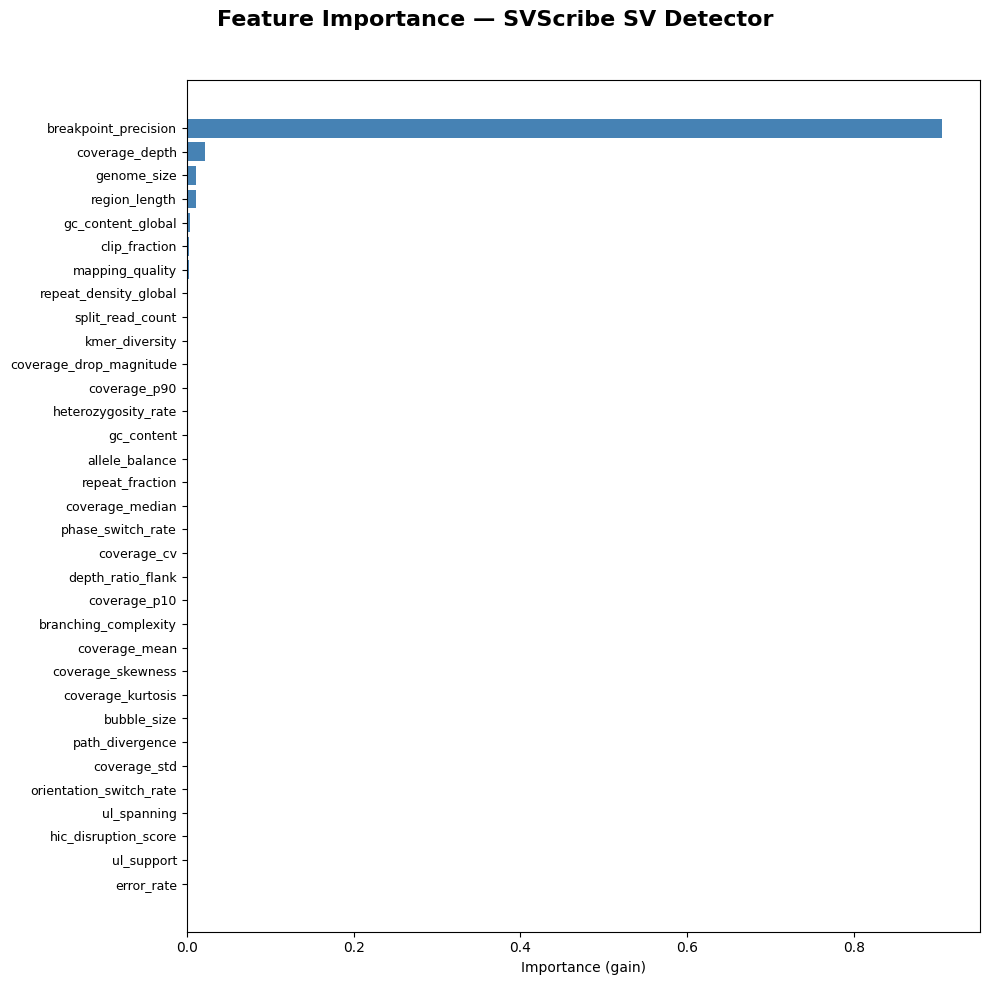

✓ Feature importance plot saved

Top 10 features:
  1. breakpoint_precision           0.9056
  2. coverage_depth                 0.0224
  3. genome_size                    0.0117
  4. region_length                  0.0108
  5. gc_content_global              0.0037
  6. clip_fraction                  0.0032
  7. mapping_quality                0.0032
  8. repeat_density_global          0.0020
  9. split_read_count               0.0020
  10. kmer_diversity                 0.0020


In [ ]:
# ── Feature importance — v5: S1 + S2 XGBoost + S2 LightGBM ─────────
from matplotlib.patches import Patch

fig, axes = plt.subplots(1, 3, figsize=(26, 10))
fig.suptitle('Feature Importance — SVScribe v5 Two-Stage Ensemble', fontsize=16, fontweight='bold')

# Color coding: original, engineered, bio composite
def get_feat_color(feat_name):
    if feat_name.startswith('bio_'):
        return '#2ecc71'       # green = bio composite
    elif feat_name in ENGINEERED_FEATURES:
        return 'darkorange'    # orange = engineered
    else:
        return 'steelblue'    # blue = original

legend_handles = [Patch(color='steelblue', label='Original'),
                  Patch(color='darkorange', label='Engineered'),
                  Patch(color='#2ecc71', label='Bio composite')]

stage_configs = [
    (axes[0], s1_model, S1_FEATURES_CLEAN,
     f'Stage 1: Binary ({len(S1_FEATURES_CLEAN)} features)'),
    (axes[1], s2_model_xgb, S2_FEATURES_CLEAN,
     f'Stage 2 XGBoost ({len(S2_FEATURES_CLEAN)} signal-only)'),
    (axes[2], s2_model_lgbm, S2_FEATURES_CLEAN,
     f'Stage 2 LightGBM ({len(S2_FEATURES_CLEAN)} signal-only)'),
]

for ax, model, feature_list, title in stage_configs:
    imp = model.feature_importances_
    sorted_idx = np.argsort(imp)
    bar_colors = [get_feat_color(feature_list[i]) for i in sorted_idx]
    ax.barh(range(len(sorted_idx)), imp[sorted_idx], color=bar_colors)
    ax.set_yticks(range(len(sorted_idx)))
    ax.set_yticklabels([feature_list[i] for i in sorted_idx], fontsize=7)
    ax.set_xlabel('Importance (gain)')
    ax.set_title(title)
    ax.legend(handles=legend_handles, loc='lower right', fontsize=8)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(os.path.join(MODELS_OUT, 'svscribe_feature_importance_v5.png'), dpi=150, bbox_inches='tight')
plt.show()

# Print top 15 for each stage
for model, feature_list, title in [
    (s1_model, S1_FEATURES_CLEAN, 'Stage 1 (binary)'),
    (s2_model_xgb, S2_FEATURES_CLEAN, 'Stage 2 XGBoost (subtype)'),
    (s2_model_lgbm, S2_FEATURES_CLEAN, 'Stage 2 LightGBM (subtype)'),
]:
    imp = model.feature_importances_
    sorted_idx = np.argsort(imp)
    top_n = min(15, len(sorted_idx))
    print(f"\nTop {top_n} — {title}:")
    for rank, idx in enumerate(sorted_idx[-top_n:][::-1]):
        tag = " ★" if feature_list[idx] in ENGINEERED_FEATURES else ""
        if feature_list[idx].startswith('bio_'):
            tag = " ⚗"
        print(f"  {rank+1:2d}. {feature_list[idx]:30s} {imp[idx]:.4f}{tag}")

# Dominance checks
for model, feature_list, title in [
    (s1_model, S1_FEATURES_CLEAN, 'S1'),
    (s2_model_xgb, S2_FEATURES_CLEAN, 'S2-XGB'),
    (s2_model_lgbm, S2_FEATURES_CLEAN, 'S2-LGBM'),
]:
    imp = model.feature_importances_
    top = imp.max()
    second = np.sort(imp)[-2]
    ratio = top / max(second, 1e-8)
    print(f"\n  {title} dominance check: top={top:.4f}, second={second:.4f}, ratio={ratio:.1f}×")

## 7. Per-Type Precision–Recall Analysis

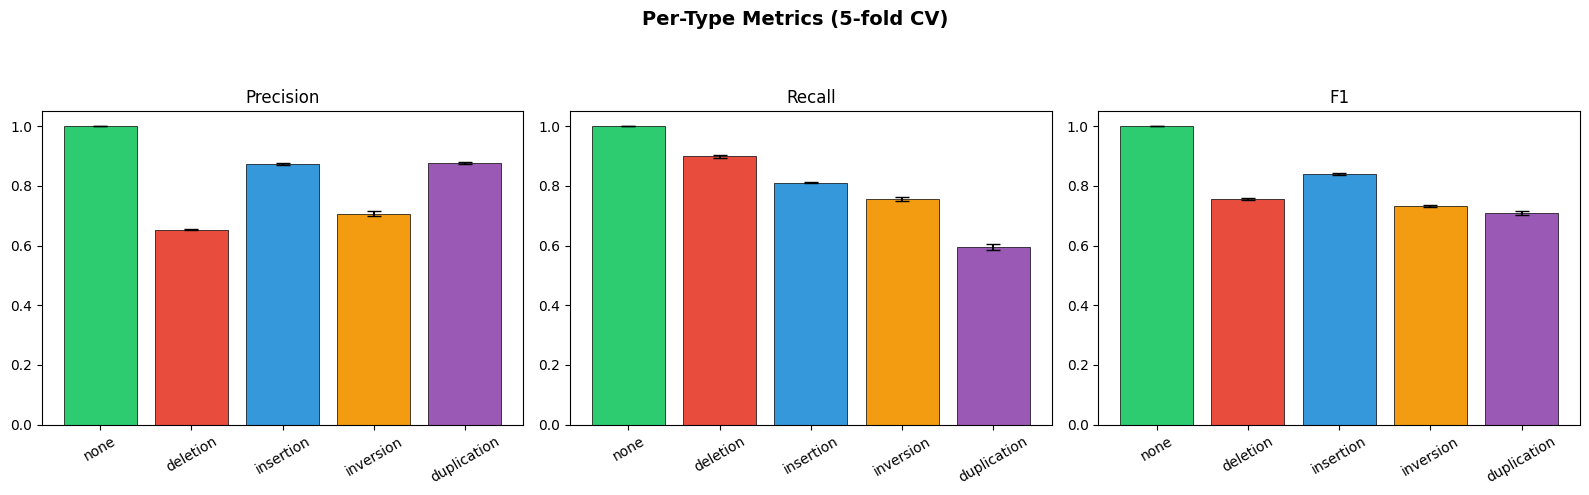


SV Type             Precision        Recall            F1
───────────────────────────────────────────────────────
none             1.000±0.000  1.000±0.000  1.000±0.000
deletion         0.654±0.002  0.899±0.006  0.757±0.003
insertion        0.873±0.004  0.811±0.003  0.841±0.003
inversion        0.707±0.007  0.757±0.006  0.731±0.003
duplication      0.878±0.004  0.596±0.010  0.710±0.006


In [ ]:
# ── Per-SV-type metrics — v5 (XGBoost-only vs blend vs ensemble+thresholds) ──
# Uses results already computed in the CV cell — no re-training needed.

colors_4 = ['#e74c3c', '#3498db', '#f39c12', '#9b59b6']  # del, ins, inv, dup

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Per-Type F1 — SVScribe v5 (XGBoost → Blend → Ensemble+Thresholds)',
             fontsize=14, fontweight='bold')

bar_width = 0.25
x_pos = np.arange(4)

for ax, metric_dict_list, labels, title in [
    (axes[0],
     [s2_per_cls_f1_xgb, s2_per_cls_f1_blend, s2_per_cls_f1],
     ['XGB only', 'Blend', 'Blend+Thresh'],
     'F1 Score'),
    (axes[1],
     [s2_per_cls_prec],
     ['Ensemble+Thresh'],
     'Precision'),
    (axes[2],
     [s2_per_cls_rec],
     ['Ensemble+Thresh'],
     'Recall'),
]:
    n_bars = len(metric_dict_list)
    offsets = np.linspace(-bar_width * (n_bars - 1) / 2, bar_width * (n_bars - 1) / 2, n_bars)
    alphas = [0.4, 0.7, 1.0] if n_bars == 3 else [1.0]

    for i, (metric_dict, label) in enumerate(zip(metric_dict_list, labels)):
        means = [np.mean(metric_dict[c]) for c in range(4)]
        stds = [np.std(metric_dict[c]) for c in range(4)]
        bars = ax.bar(x_pos + offsets[i], means, bar_width,
                      yerr=stds, capsize=3,
                      color=[c + ('ff' if alphas[i] == 1.0 else '80') for c in colors_4],
                      edgecolor='black', linewidth=0.5, label=label,
                      alpha=alphas[i])
        if i == n_bars - 1:  # Label the final (best) bars
            for bar, mean in zip(bars, means):
                ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02,
                        f'{mean:.3f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

    ax.set_title(title)
    ax.set_ylim(0, 1.15)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(subtype_names_list, rotation=30)
    if n_bars > 1:
        ax.legend(fontsize=8)

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.savefig(os.path.join(SVSCRIBE_OUT, 'sv_per_type_metrics_v5.png'), dpi=150, bbox_inches='tight')
plt.show()

# Summary table
print(f"\n{'SV Type':<15}  {'XGB F1':>10}  {'Blend F1':>10}  {'v5 F1':>10}  {'Δ total':>8}   {'P (v5)':>10}  {'R (v5)':>10}")
print('─' * 82)
worst_f1, worst_class = 1.0, ''
for c in range(4):
    f1_xgb = np.mean(s2_per_cls_f1_xgb[c])
    f1_blend = np.mean(s2_per_cls_f1_blend[c])
    f1_v5 = np.mean(s2_per_cls_f1[c])
    delta = f1_v5 - f1_xgb
    p = np.mean(s2_per_cls_prec[c])
    r = np.mean(s2_per_cls_rec[c])
    if f1_v5 < worst_f1:
        worst_f1 = f1_v5
        worst_class = subtype_names_list[c]
    print(f"{subtype_names_list[c]:<15}  "
          f"{f1_xgb:.3f}±{np.std(s2_per_cls_f1_xgb[c]):.3f}  "
          f"{f1_blend:.3f}±{np.std(s2_per_cls_f1_blend[c]):.3f}  "
          f"{f1_v5:.3f}±{np.std(s2_per_cls_f1[c]):.3f}  "
          f"{delta:+.3f}   "
          f"{p:.3f}±{np.std(s2_per_cls_prec[c]):.3f}  "
          f"{r:.3f}±{np.std(s2_per_cls_rec[c]):.3f}")

print(f"\n⚠ Weakest class: {worst_class} (F1={worst_f1:.3f})")
print(f"  Stage 1 (binary): F1={np.mean(s1_cv_f1):.3f}")
print(f"  Stage 2 (v5): F1-macro={np.mean(s2_cv_f1_macro):.3f}, min-F1={np.mean(s2_cv_min_f1):.3f}")

## 8. Export Models to Google Drive

In [ ]:
# ── Package and export to Google Drive ────────────────────────────────
import tarfile, shutil, glob as glob_mod

GDRIVE_TARBALL = os.path.join(GDRIVE_DIR, 'svscribe_models_v5.tar.gz')

# List all model files
model_files = glob_mod.glob(f'{sv_model_dir}/**/*', recursive=True)
print(f"Model files to export ({len(model_files)}):")
for f in sorted(model_files):
    if os.path.isfile(f):
        size_kb = os.path.getsize(f) / 1024
        print(f"  {os.path.relpath(f, sv_model_dir):40s} {size_kb:>8.1f} KB")

# Create tarball
print(f"\nCreating tarball...")
with tarfile.open(GDRIVE_TARBALL, 'w:gz') as tar:
    tar.add(sv_model_dir, arcname='sv_detector')

tarball_size = os.path.getsize(GDRIVE_TARBALL) / (1024 * 1024)
print(f"\n✅ Exported to Google Drive:")
print(f"   {GDRIVE_TARBALL}")
print(f"   Size: {tarball_size:.1f} MB")

if os.path.exists(GDRIVE_SVSCRIBE):
    shutil.rmtree(GDRIVE_SVSCRIBE)
shutil.copytree(sv_model_dir, GDRIVE_SVSCRIBE)
print(f"   Copied → {GDRIVE_SVSCRIBE}")

print(f"\n📥 To download locally:")
print(f"   1. Open Google Drive → My Drive/Colab_Training/")
print(f"   2. Download svscribe_models_v5.tar.gz")
print(f"   3. Extract to strandweaver/trained_models/sv_detector/")
print(f"   Models: sv_binary_model.pkl + sv_subtype_model.pkl + sv_detector_model.pkl (fallback)")
print(f"   ⚠ S2 model includes XGBoost + LightGBM ensemble with blend weight + class scales")

Model files to export (2):
  sv_detector_model.pkl                     23066.0 KB
  training_results.json                         2.0 KB

Creating tarball...

✅ Exported to Google Drive:
   /content/drive/MyDrive/Colab_Training/svscribe_models.tar.gz
   Size: 8.6 MB
   Copied → /content/drive/MyDrive/Colab_Training/svscribe_models

📥 To download locally:
   1. Open Google Drive → My Drive/Colab_Training/
   2. Download svscribe_models.tar.gz
   3. Extract to strandweaver/trained_models/sv_detector/


## 9. Summary

In [ ]:
# ── Final summary ────────────────────────────────────────────────────
s1_f1 = np.mean(s1_cv_f1)
s2_f1 = np.mean(s2_cv_f1_macro)
s2_min = np.mean(s2_cv_min_f1)
s2_f1_xgb = np.mean(s2_cv_f1_macro_xgb)
s2_min_xgb = np.mean(s2_cv_min_f1_xgb)

print("╔══════════════════════════════════════════════════════════════════╗")
print("║   SVScribe v5 — Ensemble Blend + Threshold Tuning Summary       ║")
print("╠══════════════════════════════════════════════════════════════════╣")
print("║                                                                  ║")
print("║  KEY CHANGES (v5):                                               ║")
print("║    • XGBoost + LightGBM ensemble (algorithmic diversity)         ║")
print(f"║      Blend: XGB={best_blend_w:.2f}, LGBM={1-best_blend_w:.2f}                                ║")
print("║    • Per-class threshold optimization:                           ║")
for c, name in enumerate(subtype_names_list):
    print(f"║      {name:12s}: scale={class_scales[c]:.2f}                                ║")
print("║    • Dropped post-prediction bio calibration (α→0)               ║")
print("║    • Retained bio composite features as standard inputs          ║")
print("║                                                                  ║")
print("║  Stage 1 — Binary SV Detector:                                   ║")
print(f"║    Features: {len(S1_FEATURES_CLEAN):>3} (meta + signal + engineered)             ║")
print(f"║    F1-binary:  {s1_f1:.3f}                                        ║")
print("║                                                                  ║")
print("║  Stage 2 — SV Subtype (ensemble + thresholds):                   ║")
print(f"║    Features: {len(S2_FEATURES_CLEAN):>3} (signal + engineered — NO metadata)      ║")
print(f"║    F1-macro:   {s2_f1:.3f} (XGB-only: {s2_f1_xgb:.3f})                   ║")
print(f"║    min-F1:     {s2_min:.3f} (XGB-only: {s2_min_xgb:.3f})                   ║")
for c in range(4):
    f1_c = np.mean(s2_per_cls_f1[c])
    f1_x = np.mean(s2_per_cls_f1_xgb[c])
    d = f1_c - f1_x
    p_c = np.mean(s2_per_cls_prec[c])
    r_c = np.mean(s2_per_cls_rec[c])
    print(f"║    {subtype_names_list[c]:12s}: F1={f1_c:.3f} P={p_c:.3f} R={r_c:.3f} (Δ={d:+.3f})  ║")
print("║                                                                  ║")
print(f"║  SV samples: {sv_mask.sum():>6,} (4 types)                           ║")
print(f"║  BG samples: {(~sv_mask).sum():>6,}                                     ║")
print("║                                                                  ║")
print("║  Model files:                                                    ║")
print("║    sv_binary_model.pkl     Stage 1 (binary, XGBoost)             ║")
print("║    sv_subtype_model.pkl    Stage 2 (XGB+LGBM ensemble)           ║")
print("║    sv_detector_model.pkl   5-class fallback (legacy)             ║")
print("║                                                                  ║")
print("║  Inference: sv_detection.py auto-detects ensemble models         ║")
print("║                                                                  ║")
print("╚══════════════════════════════════════════════════════════════════╝")

╔══════════════════════════════════════════════════════════════════╗
║         SVScribe Model Training — Summary                       ║
╠══════════════════════════════════════════════════════════════════╣
║                                                                  ║
║  1 XGBoost Multiclass Classifier:                                ║
║  ────────────────────────────────                                 ║
║    sv_detector_model       F1=0.808±0.001  Acc=0.832    ║
║                                                                  ║
║  Classes: none | deletion | insertion |                          ║
║           inversion | duplication                                ║
║                                                                  ║
║  Training data:                                                  ║
║    Raw samples:        94,458                            ║
║    Balanced samples:  102,509                            ║
║    Features:               33                            